# Preprocessing

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
pd.set_option('display.max_columns', None)

## 1. Clean data
### 1.1. Fighters

In [ ]:
fighters = pd.read_csv("data/fighters.csv")
# fighters

In [ ]:
fighters["DOB"] = pd.to_datetime(fighters["DOB"])
fighters

In [ ]:
fighters.dtypes

Looks good

### 1.2. Bouts

In [ ]:
bouts_raw = pd.read_csv("data/bouts_raw.csv")
bouts_raw = bouts_raw[bouts_raw.columns[1:]]
# bouts_raw
bouts_raw["Date"] = pd.to_datetime(bouts_raw["Date"])
bouts_raw

In [ ]:
bouts = bouts_raw.copy()
# bouts["Format"].unique()

bouts["Time"] = bouts["Time"].str.split(":").apply(lambda x: int(x[0]) + (int(x[1]) / 60.0))
# bouts["Time"]
bouts["Total Time"] = np.nan

# yanderedev moment
def total_time(form, rnd, tm):
    nothing = {"No Time Limit", "1 Rnd (20)", "1 Rnd (30)", "1 Rnd (15)", "1 Rnd (18)", "1 Rnd (10)", "1 Rnd (12)", 
               "Unlimited Rnd (10)", "Unlimited Rnd  (15)", "Unlimited Rnd (20)"}
    thirty_OT = {"1 Rnd + OT (30-5)", "1 Rnd + OT (30-3)"}
    fifteen_OT = {"1 Rnd + OT (15-3)", "1 Rnd + OT (15-10)"}
    tens = {"3 Rnd (10-10-10)", "4 Rnd (10-10-10-10)", "2 Rnd (10-10)", "3 Rnd (10-10-5)", "2 Rnd (10-5)"}
    fives = {"2 Rnd (5-5)", "3 Rnd (5-5-5)", "5 Rnd (5-5-5-5-5)", "3 Rnd + OT (5-5-5-5)"}
    fours = {"3 Rnd (4-4-4)", "5 Rnd (4-4-4-4-4)"}
    threes = {"5 Rnd (3-3-3-3-3)", "3 Rnd (3-3-3)", "2 Rnd (3-3)"}
    
    
    if form in nothing:
        return tm
    elif form == "1 Rnd + OT (31-5)":
        return tm + 31*(rnd - 1)
    elif form in thirty_OT:
        return tm + 30*(rnd - 1)
    elif form == "1 Rnd + OT (27-3)":
        return tm + 27*(rnd - 1)
    elif form in fifteen_OT:
        return tm + 15*(rnd - 1)
    elif form == "1 Rnd + OT (12-3)":
        return tm + 12*(rnd - 1)
    elif form in tens:
        return tm + 10*(rnd - 1)
    elif form == "3 Rnd (8-8-8)":
        return tm + 8*(rnd - 1)
    elif form in fives:
        return tm + 5*(rnd - 1)
    elif form in fours:
        return tm + 4*(rnd - 1)
    elif form in threes:
        return tm + 3*(rnd - 1)
    elif form == "3 Rnd (2-2-2)":
        return tm + 2*(rnd - 1)
    elif form == "1 Rnd + 2OT (24-3-3)":
        if rnd == 1:
            return tm
        else:
            return 24 + tm + 3*(rnd - 2)
    elif form == "1 Rnd + 2OT (15-3-3)":
        if rnd == 1:
            return tm
        else:
            return 15 + tm + 3*(rnd - 2)
    elif form == "3 Rnd (10-5-5)":
        if rnd == 1:
            return tm
        else:
            return 10 + 5*(rnd - 2)

bouts["Total Time"] = bouts.apply(lambda x: total_time(x["Format"], x["Round"], x["Time"]), axis=1)

def ctrl_time(x):
    if not pd.isnull(x):
        if x == "--":
            return np.nan
        else:
            temp = x.split(":")
            return int(temp[0]) + (int(temp[1]) / 60.0)
bouts["R_Ctrl"] = bouts["R_Ctrl"].apply(lambda x: ctrl_time(x))
bouts["B_Ctrl"] = bouts["B_Ctrl"].apply(lambda x: ctrl_time(x))

def of_split(x, num):
    if not pd.isnull(x):
        if x == "---":
            return np.nan
        else:
            return int(x.split(" of ")[num])
            

bouts["R_Sig. Str. Landed"] = bouts["R_Sig. Str."].apply(lambda x: of_split(x, 0))
bouts["R_Sig. Str. Attempted"] = bouts["R_Sig. Str."].apply(lambda x: of_split(x, 1))
bouts["B_Sig. Str. Landed"] = bouts["B_Sig. Str."].apply(lambda x: of_split(x, 0))
bouts["B_Sig. Str. Attempted"] = bouts["B_Sig. Str."].apply(lambda x: of_split(x, 1))

bouts["R_Total Str. Landed"] = bouts["R_Total Str."].apply(lambda x: of_split(x, 0))
bouts["R_Total Str. Attempted"] = bouts["R_Total Str."].apply(lambda x: of_split(x, 1))
bouts["B_Total Str. Landed"] = bouts["B_Total Str."].apply(lambda x: of_split(x, 0))
bouts["B_Total Str. Attempted"] = bouts["B_Total Str."].apply(lambda x: of_split(x, 1))

bouts["R_TD Landed"] = bouts["R_TD"].apply(lambda x: of_split(x, 0))
bouts["R_TD Attempted"] = bouts["R_TD"].apply(lambda x: of_split(x, 1))
bouts["B_TD Landed"] = bouts["B_TD"].apply(lambda x: of_split(x, 0))
bouts["B_TD Attempted"] = bouts["B_TD"].apply(lambda x: of_split(x, 1))

def string_percent(x):
    if not pd.isnull(x):
        if x == "---":
            return np.nan
        else:
            return int(x.replace("%", ""))

bouts["R_Sig. Str. %"] = bouts["R_Sig. Str. %"].apply(lambda x: string_percent(x))
bouts["B_Sig. Str. %"] = bouts["B_Sig. Str. %"].apply(lambda x: string_percent(x))

bouts["R_TD %"] = bouts["R_TD %"].apply(lambda x: string_percent(x))
bouts["B_TD %"] = bouts["B_TD %"].apply(lambda x: string_percent(x))

bouts["R_Ctrl"] = bouts["R_Ctrl"].fillna(0.0)
bouts["B_Ctrl"] = bouts["B_Ctrl"].fillna(0.0)

In [ ]:
columns = ["URL", "Event", "Date", "R_Name", "B_Name", "R_Result", "B_Result", "Bout Type", "Method", "Round", "Time", 
           "Format", "Total Time", "Referee", "R_KD", "B_KD", "R_Sig. Str. Landed", "R_Sig. Str. Attempted", "R_Sig. Str. %",
           "B_Sig. Str. Landed", "B_Sig. Str. Attempted", "B_Sig. Str. %", "R_Total Str. Landed", "R_Total Str. Attempted", 
           "B_Total Str. Landed", "B_Total Str. Attempted", "R_TD Landed", "R_TD Attempted", "R_TD %", "B_TD Landed", 
           "B_TD Attempted", "B_TD %", "R_Sub. Att", "B_Sub. Att", "R_Rev.", "B_Rev.", "R_Ctrl", "B_Ctrl"]
bouts_clean = bouts[columns]

In [ ]:
bouts_clean

In [ ]:
bouts_clean.dtypes

In [ ]:
# bouts_clean.to_csv("data/bouts_clean.csv", index=False, header=True)

### 1.3. Odds

In [ ]:
odds_raw = pd.read_csv("data/bestfightodds_raw.csv")
odds_raw

In [ ]:
odds_raw.dtypes

In [ ]:
# There are some typos in the names, need to cross reference with fighters data
# I'm so sorry for this code block
odds_clean = odds_raw.copy()
odds_clean.loc[odds_clean["name"] == "Edilberto Crocota", "name"] = "Edilberto de Oliveira"
odds_clean.loc[odds_clean["name"] == "Jason Macdonald", "name"] = "Jason MacDonald"
odds_clean.loc[odds_clean["name"] == "Josh Burkman", "name"] = "Joshua Burkman"
odds_clean.loc[odds_clean["name"] == "Rameau Sokoudjou", "name"] = "Rameau Thierry Sokoudjou"
odds_clean.loc[odds_clean["name"] == "Tony Desouza", "name"] = "Tony DeSouza"
odds_clean.loc[odds_clean["name"] == "Luis Cane", "name"] = "Luiz Cane"
odds_clean.loc[odds_clean["name"] == "Manny Gamburyan", "name"] = "Manvel Gamburyan"
odds_clean.loc[odds_clean["name"] == "B.J. Penn", "name"] = "BJ Penn"
odds_clean.loc[odds_clean["name"] == "Kimbo Slice", "name"] = "Kevin Ferguson"
odds_clean.loc[odds_clean["name"] == "James Edson Berto", "name"] = "Edson Berto"
odds_clean.loc[odds_clean["name"] == "Jake O Brien", "name"] = "Jake O'Brien"
odds_clean.loc[odds_clean["name"] == "Bruno Gustavo da Silva", "name"] = "Bruno Silva"
odds_clean.loc[odds_clean["name"] == "Rukasz Brzeski", "name"] = "Lukasz Brzeski"
odds_clean.loc[odds_clean["name"] == "Darmon Blackshear", "name"] = "Da'Mon Blackshear"
odds_clean.loc[odds_clean["name"] == "Charles Johnson.", "name"] = "Charles Johnson"
odds_clean.loc[odds_clean["name"] == "Lee Jeong-Yeong", "name"] = "JeongYeong Lee"
odds_clean.loc[odds_clean["name"] == "Choi Doo-Ho", "name"] = "Dooho Choi"
odds_clean.loc[odds_clean["name"] == "Luan Luiz Lacerda", "name"] = "Luan Lacerda"
odds_clean.loc[odds_clean["name"] == "Dan Arguetta", "name"] = "Dan Argueta"
odds_clean.loc[odds_clean["name"] == "Nick Fiore.", "name"] = "Nick Fiore"
odds_clean.loc[odds_clean["name"] == "Mateusz Rrbecki", "name"] = "Mateusz Rebecki"
odds_clean.loc[odds_clean["name"] == "Daniel Argueta", "name"] = "Dan Argueta"
odds_clean.loc[odds_clean["name"] == "Jan Brachowicz", "name"] = "Jan Blachowicz"
odds_clean.loc[odds_clean["name"] == "Nathan Levy", "name"] = "Natan Levy"
odds_clean.loc[odds_clean["name"] == "Mark O. Madsen", "name"] = "Mark Madsen"
# Still 461 weird cases ???
odds_clean.loc[odds_clean["name"] == "Bala Jin", "name"] = "Balajin"
odds_clean.loc[odds_clean["name"] == "Jeka Asparido Saragih", "name"] = "Jeka Saragih"
odds_clean.loc[odds_clean["name"] == "Lajin Ba", "name"] = "Balajin"
odds_clean.loc[odds_clean["name"] == "Thanongsaklek Chuwattana", "name"] = "Top Noi Kiwram"
odds_clean.loc[odds_clean["name"] == "Jeongyeong Lee", "name"] = "JeongYeong Lee"
odds_clean.loc[odds_clean["name"] == "Tj Dillashaw", "name"] = "TJ Dillashaw"
odds_clean.loc[odds_clean["name"] == "A.J. Dobson", "name"] = "AJ Dobson"
odds_clean.loc[odds_clean["name"] == "Lucas Alexander.", "name"] = "Lucas Alexander"
odds_clean.loc[odds_clean["name"] == "Yan Xiaonan.", "name"] = "Yan Xiaonan"
odds_clean.loc[odds_clean["name"] == "Rafael Esteves", "name"] = "Rafael Estevam"
odds_clean.loc[odds_clean["name"] == "Rafael Ramos", "name"] = "Rafael Estevam"
odds_clean.loc[odds_clean["name"] == "Freddy Linares", "name"] = "Emiliano Linares"
odds_clean.loc[odds_clean["name"] == "Raul Rosas Jr", "name"] = "Raul Rosas Jr."
odds_clean.loc[odds_clean["name"] == "Jailtom Almeida", "name"] = "Jailton Almeida"
odds_clean.loc[odds_clean["name"] == "Mellisa Martinez", "name"] = "Melissa Martinez"
odds_clean.loc[odds_clean["name"] == "William Gomi", "name"] = "William Gomis"
odds_clean.loc[odds_clean["name"] == "Alex Morgan", "name"] = "Alexander Morgan"
odds_clean.loc[odds_clean["name"] == "Viktoriya Dudakova", "name"] = "Viktoriia Dudakova"
odds_clean.loc[odds_clean["name"] == "Josh Wang-Kim", "name"] = "Joshua Wang-Kim"
odds_clean.loc[odds_clean["name"] == "Jesus Santos Aguilar", "name"] = "Jesus Aguilar"
odds_clean.loc[odds_clean["name"] == "Michael Parkin", "name"] = "Mick Parkin"
odds_clean.loc[odds_clean["name"] == "Da'mon Blackshear", "name"] = "Da'Mon Blackshear"
odds_clean.loc[odds_clean["name"] == "Paulo Renato Jr", "name"] = "Paulo Renato Junior"
odds_clean.loc[odds_clean["name"] == "Brogan Walker-Sanchez", "name"] = "Brogan Walker"
odds_clean.loc[odds_clean["name"] == "Joselyne Edwards.", "name"] = "Joselyne Edwards"
odds_clean.loc[odds_clean["name"] == "Kai Kara-France.", "name"] = "Kai Kara-France"
odds_clean.loc[odds_clean["name"] == "Willian Souza", "name"] = "Willian Colorado"
odds_clean.loc[odds_clean["name"] == "Andres Luna Martinetti", "name"] = "Juan Andres Luna"
odds_clean.loc[odds_clean["name"] == "Damir Hadrovir", "name"] = "Damir Hadzovic"
odds_clean.loc[odds_clean["name"] == "Cody Brundage.", "name"] = "Cody Brundage"
odds_clean.loc[odds_clean["name"] == "Danaa Batgerel.", "name"] = "Batgerel Danaa"
odds_clean.loc[odds_clean["name"] == "Hayisaer Maheshate", "name"] = "Maheshate"
odds_clean.loc[odds_clean["name"] == "Joshua Culibao", "name"] = "Josh Culibao"
odds_clean.loc[odds_clean["name"] == "Ye Dam Seo", "name"] = "YeDam Seo"
odds_clean.loc[odds_clean["name"] == "Topnoi Kiwram", "name"] = "Top Noi Kiwram"
odds_clean.loc[odds_clean["name"] == "Jung Young Lee", "name"] = "JeongYeong Lee"
odds_clean.loc[odds_clean["name"] == "Han Seul Kim", "name"] = "HanSeul Kim"
odds_clean.loc[odds_clean["name"] == "Kai Lu", "name"] = "Lu Kai"
odds_clean.loc[odds_clean["name"] == "Angga Hans", "name"] = "Angga"
odds_clean.loc[odds_clean["name"] == "Hyun Sung Park", "name"] = "HyunSung Park"
odds_clean.loc[odds_clean["name"] == "Kyung Pyo Kim", "name"] = "KyeungPyo Kim"
odds_clean.loc[odds_clean["name"] == "Asikerbai Jinensibieke", "name"] = "Jinensibieke Asikeerbai"
odds_clean.loc[odds_clean["name"] == "Mingyang Zhang", "name"] = "Zhang Mingyang"
odds_clean.loc[odds_clean["name"] == "George Tokkos", "name"] = "Tuco Tokkos"
odds_clean.loc[odds_clean["name"] == "Seung Guk Choi", "name"] = "SeungGuk Choi"
odds_clean.loc[odds_clean["name"] == "Keremuaili Maimaitituoheti", "name"] = "Maimaitituoheti Keremuaili"
odds_clean.loc[odds_clean["name"] == "Won Bin Ki", "name"] = "WonBin Ki"
odds_clean.loc[odds_clean["name"] == "Zha Yi", "name"] = "Yi Zha"
odds_clean.loc[odds_clean["name"] == "Min Woo Kim", "name"] = "MinWoo Kim"
odds_clean.loc[odds_clean["name"] == "Pawan Maan Singh", "name"] = "Pawan Maan"
odds_clean.loc[odds_clean["name"] == "Aili Muratbek", "name"] = "Ailiya Muratbek"
odds_clean.loc[odds_clean["name"] == "Jun Young Hong", "name"] = "JunYoung Hong"
odds_clean.loc[odds_clean["name"] == "Johnny Munoz Jr.", "name"] = "Johnny Munoz"
odds_clean.loc[odds_clean["name"] == "Benoit Saint-Denis", "name"] = "Benoit Saint Denis"
odds_clean.loc[odds_clean["name"] == "Daniel Argueta.", "name"] = "Dan Argueta"
odds_clean.loc[odds_clean["name"] == "Cameron Vancamp", "name"] = "Cameron VanCamp"
odds_clean.loc[odds_clean["name"] == "Daniel da Silva", "name"] = "Daniel Lacerda"
odds_clean.loc[odds_clean["name"] == "Grant Dawson.", "name"] = "Grant Dawson"
odds_clean.loc[odds_clean["name"] == "Andrei Arlovski.", "name"] = "Andrei Arlovski"
odds_clean.loc[odds_clean["name"] == "Aori Qileng", "name"] = "Aoriqileng"
odds_clean.loc[odds_clean["name"] == "Trey Ogden.", "name"] = "Trey Ogden"
odds_clean.loc[odds_clean["name"] == "Mike Malott.", "name"] = "Mike Malott"
odds_clean.loc[odds_clean["name"] == "Michael Malott", "name"] = "Mike Malott"
odds_clean.loc[odds_clean["name"] == "Timur Valiev.", "name"] = "Timur Valiev"
odds_clean.loc[odds_clean["name"] == "Kamuela Kirk.", "name"] = "Kamuela Kirk"
odds_clean.loc[odds_clean["name"] == "Khalil Rountree Jr", "name"] = "Khalil Rountree Jr."
odds_clean.loc[odds_clean["name"] == "Rudovit Klein", "name"] = "Ludovit Klein"
odds_clean.loc[odds_clean["name"] == "Ramona Pascual.", "name"] = "Ramona Pascual"
odds_clean.loc[odds_clean["name"] == "Wellington Turman.", "name"] = "Wellington Turman"
odds_clean.loc[odds_clean["name"] == "Diana Belbirr", "name"] = "Diana Belbita"
odds_clean.loc[odds_clean["name"] == "Jamie Pickett.", "name"] = "Jamie Pickett"
odds_clean.loc[odds_clean["name"] == "Mike Mathetha", "name"] = "Blood Diamond"
odds_clean.loc[odds_clean["name"] == "Pete Rodrigue.", "name"] = "Pete Rodriguez"
odds_clean.loc[odds_clean["name"] == "Calvin Cattar", "name"] = "Calvin Kattar"
odds_clean.loc[odds_clean["name"] == "Victor Henry.", "name"] = "Victor Henry"
odds_clean.loc[odds_clean["name"] == "Abusupiyan Magomedov", "name"] = "Abus Magomedov"
odds_clean.loc[odds_clean["name"] == "Durko Todorovir", "name"] = "Dusko Todorovic"
odds_clean.loc[odds_clean["name"] == "Nuerdanbieke Shayilan", "name"] = "Shayilan Nuerdanbieke"
odds_clean.loc[odds_clean["name"] == "Kang Kyung-Ho", "name"] = "Kyung Ho Kang"
odds_clean.loc[odds_clean["name"] == "Kennedy Nzechukwu.", "name"] = "Kennedy Nzechukwu"
odds_clean.loc[odds_clean["name"] == "Ode' Osbourne", "name"] = "Ode Osbourne"
odds_clean.loc[odds_clean["name"] == "Carlos Vergara", "name"] = "CJ Vergara"
odds_clean.loc[odds_clean["name"] == "Bin Xie", "name"] = "Xie Bin"
odds_clean.loc[odds_clean["name"] == "Qihui Yan", "name"] = "Yan Qihui"
odds_clean.loc[13455, "event"] = "DWCS 5.9"
odds_clean.loc[13455, "date"] = pd.to_datetime("2021-10-26")
odds_clean.loc[odds_clean["name"] == "Long Xiao", "name"] = "Xiao Long"
odds_clean.loc[13454, "event"] = "DWCS 5.9"
odds_clean.loc[13454, "date"] = "2021-10-26"
odds_clean.loc[odds_clean["name"] == "Christian Quinonez", "name"] = "Cristian Quinonez"
odds_clean.loc[odds_clean["name"] == "Zhifa Shang", "name"] = "Shang Zhifa"
odds_clean.loc[odds_clean["name"] == "Lun Qiu", "name"] = "Qiu Lun"
odds_clean.loc[odds_clean["name"] == "Andre Petroski.", "name"] = "Andre Petroski"
odds_clean.loc[odds_clean["name"] == "Michar Oleksiejczuk", "name"] = "Michal Oleksiejczuk"
odds_clean.loc[odds_clean["name"] == "Benoit St.Denis", "name"] = "Benoit Saint Denis"
odds_clean.loc[odds_clean["name"] == "Maria de Oliveira Neta", "name"] = "Maria Oliveira"
odds_clean.loc[odds_clean["name"] == "Slava Borschev", "name"] = "Viacheslav Borshchev"
odds_clean.loc[odds_clean["name"] == "Chris Dunan", "name"] = "Chris Duncan"
odds_clean.loc[odds_clean["name"] == "Silvana Gomez Juarez.", "name"] = "Silvana Gomez Juarez"
odds_clean.loc[odds_clean["name"] == "Phillip Hawes", "name"] = "Phil Hawes"
odds_clean.loc[odds_clean["name"] == "Lukasz Sudolski", "name"] = "Lucasz Sudolski"
odds_clean.loc[odds_clean["name"] == "Igor Poterya", "name"] = "Ihor Potieria"
odds_clean.loc[odds_clean["name"] == "Martin Sano Jr.", "name"] = "Martin Sano"
odds_clean.loc[odds_clean["name"] == "Aj Dobson", "name"] = "AJ Dobson"
odds_clean.loc[odds_clean["name"] == "Jp Buys.", "name"] = "JP Buys"
odds_clean.loc[odds_clean["name"] == "Ion Curelaba", "name"] = "Ion Cutelaba"
odds_clean.loc[odds_clean["name"] == "C.J. Vergara", "name"] = "CJ Vergara"
odds_clean.loc[odds_clean["name"] == "Sergey Spivak.", "name"] = "Serghei Spivac"
odds_clean.loc[odds_clean["name"] == "A.J. Fletcher", "name"] = "AJ Fletcher"
odds_clean.loc[odds_clean["name"] == "Jj Aldrich", "name"] = "JJ Aldrich"
odds_clean.loc[odds_clean["name"] == "Saidyokub Kakharamonov", "name"] = "Saidyokub Kakhramonov"
odds_clean.loc[odds_clean["name"] == "Oder Osbourne", "name"] = "Ode Osbourne"
odds_clean.loc[odds_clean["name"] == "Phillip Rowe", "name"] = "Phil Rowe"
odds_clean.loc[odds_clean["name"] == "Kai Kamaka Iii.", "name"] = "Kai Kamaka"
odds_clean.loc[odds_clean["name"] == "Puna Soriano", "name"] = "Punahele Soriano"
odds_clean.loc[odds_clean["name"] == "Sean Omalley", "name"] = "Sean O'Malley"
odds_clean.loc[odds_clean["name"] == "Yilan Sha", "name"] = "Shayilan Nuerdanbieke"
odds_clean.loc[odds_clean["name"] == "K.B. Bhullar", "name"] = "KB Bhullar"
odds_clean.loc[odds_clean["name"] == "Zhu Rong", "name"] = "Rong Zhu"
odds_clean.loc[odds_clean["name"] == "Na Liang", "name"] = "Liang Na"
odds_clean.loc[odds_clean["name"] == "Qileng Aori", "name"] = "Aoriqileng"
odds_clean.loc[odds_clean["name"] == "Jeffrey Molina", "name"] = "Jeff Molina"
odds_clean.loc[odds_clean["name"] == "Lupita Godinez", "name"] = "Loopy Godinez"
odds_clean.loc[odds_clean["name"] == "Montserrat Ruiz", "name"] = "Montserrat Conejo"
odds_clean.loc[odds_clean["name"] == "Francisco Figueredo", "name"] = "Francisco Figueiredo"
odds_clean.loc[odds_clean["name"] == "Talia Santos", "name"] = "Taila Santos"
odds_clean.loc[odds_clean["name"] == "Kai Kamaka III", "name"] = "Kai Kamaka"
odds_clean.loc[odds_clean["name"] == "Ali Alqaisi", "name"] = "Ali AlQaisi"
odds_clean.loc[odds_clean["name"] == "Kb Bhullar", "name"] = "KB Bhullar"
odds_clean.loc[odds_clean["name"] == "Tj Laramie", "name"] = "TJ Laramie"
odds_clean.loc[odds_clean["name"] == "Muhammadjon Naimov", "name"] = "Muhammad Naimov"
odds_clean.loc[odds_clean["name"] == "Dinis Paiva", "name"] = "Dinis Paiva Jr."
odds_clean.loc[odds_clean["name"] == "Alexander Romanov", "name"] = "Alexandr Romanov"
odds_clean.loc[odds_clean["name"] == "Henrique Shigemoto", "name"] = "Henrique Shiguemoto"
odds_clean.loc[odds_clean["name"] == "Tafon Nchuwki", "name"] = "Tafon Nchukwi"
odds_clean.loc[odds_clean["name"] == "Leomana Martinez", "name"] = "Mana Martinez"
odds_clean.loc[odds_clean["name"] == "Khadzhimurat Bestaev", "name"] = "Khadzhi Bestaev"
odds_clean.loc[odds_clean["name"] == "Kenneth Cross", "name"] = "Ken Cross"
odds_clean.loc[odds_clean["name"] == "Cheyanne Buys", "name"] = "Cheyanne Vlismas"
odds_clean.loc[odds_clean["name"] == "Tj Brown", "name"] = "TJ Brown"
odds_clean.loc[odds_clean["name"] == "T.J. Laramie", "name"] = "TJ Laramie"
odds_clean.loc[odds_clean["name"] == "Ali Al Qaisi", "name"] = "Ali AlQaisi"
odds_clean.loc[odds_clean["name"] == "Kenny Cross", "name"] = "Ken Cross"
odds_clean.loc[odds_clean["name"] == "Jose Flores", "name"] = "Luke Flores"
odds_clean.loc[odds_clean["name"] == "Tyler Flores", "name"] = "Ty Flores"
odds_clean.loc[odds_clean["name"] == "Vincent Cachero", "name"] = "Vince Cachero"
odds_clean.loc[odds_clean["name"] == "Nathan Maness", "name"] = "Nate Maness"
odds_clean.loc[odds_clean["name"] == "Johnny Munoz Jr", "name"] = "Johnny Munoz"
odds_clean.loc[odds_clean["name"] == "Gabriel Green", "name"] = "Gabe Green"
odds_clean.loc[odds_clean["name"] == "Alex Hernandez", "name"] = "Alexander Hernandez"
odds_clean.loc[odds_clean["name"] == "Isaac Villanueva", "name"] = "Ike Villanueva"
odds_clean.loc[odds_clean["name"] == "Steve Garcia Jr.", "name"] = "Steve Garcia"
odds_clean.loc[odds_clean["name"] == "Sergey Spivac", "name"] = "Serghei Spivac"
odds_clean.loc[odds_clean["name"] == "Kalinn Williams", "name"] = "Khaos Williams"
odds_clean.loc[odds_clean["name"] == "Seungwoo Choi", "name"] = "SeungWoo Choi"
odds_clean.loc[odds_clean["name"] == "Isabella de Padua", "name"] = "Isabela de Padua"
odds_clean.loc[odds_clean["name"] == "Grigorii Popov", "name"] = "Grigory Popov"
odds_clean.loc[odds_clean["name"] == "Zarah Fairn Dos Santos", "name"] = "Zarah Fairn"
odds_clean.loc[odds_clean["name"] == "Heili Alateng", "name"] = "Alatengheili"
odds_clean.loc[odds_clean["name"] == "Danaa Batgerel", "name"] = "Batgerel Danaa"
odds_clean.loc[odds_clean["name"] == "Da Un Jung", "name"] = "Da Woon Jung"
odds_clean.loc[odds_clean["name"] == "Su Mudaerji", "name"] = "Sumudaerji"
odds_clean.loc[odds_clean["name"] == "Jun Yong Park", "name"] = "JunYong Park"
odds_clean.loc[odds_clean["name"] == "T.J. Brown", "name"] = "TJ Brown"
# 300 left mark
odds_clean.loc[odds_clean["name"] == "Sang Hoon Yoo", "name"] = "Sanghoon Yoo"
odds_clean.loc[odds_clean["name"] == "Micol Disegni", "name"] = "Micol Di Segni"
odds_clean.loc[odds_clean["name"] == "Philip Rowe", "name"] = "Phil Rowe"
odds_clean.loc[odds_clean["name"] == "Rodrigo Vargas", "name"] = "Kazula Vargas"
odds_clean.loc[odds_clean["name"] == "Luiz Garagorri", "name"] = "Eduardo Garagorri"
odds_clean.loc[odds_clean["name"] == "Marilla Santos", "name"] = "Marilia Santos"
odds_clean.loc[odds_clean["name"] == "J.J. Okanovich", "name"] = "JJ Okanovich"
odds_clean.loc[odds_clean["name"] == "Brianna van Buren", "name"] = "Brianna Fortino"
odds_clean.loc[odds_clean["name"] == "Liu Pingyuan", "name"] = "Pingyuan Liu"
odds_clean.loc[odds_clean["name"] == "Chris Ocon", "name"] = "Christian Ocon"
odds_clean.loc[odds_clean["name"] == "Joseph Solecki", "name"] = "Joe Solecki"
odds_clean.loc[odds_clean["name"] == "Jesse Wallace", "name"] = "James Wallace"
odds_clean.loc[odds_clean["name"] == "Yorgan de Castro", "name"] = "Yorgan De Castro"
odds_clean.loc[odds_clean["name"] == "Alton Meeks", "name"] = "Sanford Alton Meeks"
odds_clean.loc[odds_clean["name"] == "Carlos Huachin Quiroz", "name"] = "Carlos Huachin"
odds_clean.loc[odds_clean["name"] == "Sergey Spivak", "name"] = "Serghei Spivac"
odds_clean.loc[odds_clean["name"] == "Alex da Silva", "name"] = "Alex Da Silva"
odds_clean.loc[odds_clean["name"] == "Seung Woo Choi", "name"] = "SeungWoo Choi"
odds_clean.loc[odds_clean["name"] == "Ryan Macdonald", "name"] = "Ryan MacDonald"
odds_clean.loc[odds_clean["name"] == "Klidson Farias de Abreu", "name"] = "Klidson Abreu"
odds_clean.loc[odds_clean["name"] == "Marcos Rosa", "name"] = "Marcos Mariano"
odds_clean.loc[odds_clean["name"] == "Kai Kara France", "name"] = "Kai Kara-France"
odds_clean.loc[odds_clean["name"] == "Julia Stoliarenko", "name"] = "Julija Stoliarenko"
odds_clean.loc[odds_clean["name"] == "Sumudaerji Sumudaerji", "name"] = "Sumudaerji"
odds_clean.loc[odds_clean["name"] == "Sergey Pavlovich", "name"] = "Sergei Pavlovich"
odds_clean.loc[odds_clean["name"] == "Marcos Rogerio", "name"] = "Marcos Rogerio de Lima"
odds_clean.loc[odds_clean["name"] == "Livia Renata Souza", "name"] = "Livinha Souza"
odds_clean.loc[odds_clean["name"] == "Luigi Vandramini", "name"] = "Luigi Vendramini"
odds_clean.loc[odds_clean["name"] == "Mayra Bueno", "name"] = "Mayra Bueno Silva"
odds_clean.loc[odds_clean["name"] == "Alexey Kunchenko", "name"] = "Aleksei Kunchenko"
odds_clean.loc[odds_clean["name"] == "J.R. Coughran", "name"] = "JR Coughran"
odds_clean.loc[odds_clean["name"] == "Joseph Lowry", "name"] = "Joe Lowry"
odds_clean.loc[odds_clean["name"] == "Weili Zhang", "name"] = "Zhang Weili"
odds_clean.loc[odds_clean["name"] == "Jim Crute", "name"] = "Jimmy Crute"
odds_clean.loc[odds_clean["name"] == "Alex Munoz", "name"] = "Alexander Munoz"
odds_clean.loc[odds_clean["name"] == "Riley Dutro", "name"] = "Rilley Dutro"
odds_clean.loc[odds_clean["name"] == "Ricardo Palacios", "name"] = "Ricky Palacios"
odds_clean.loc[odds_clean["name"] == "Mike Trizano", "name"] = "Michael Trizano"
odds_clean.loc[odds_clean["name"] == "Ulka Sasaki", "name"] = "Yuta Sasaki"
odds_clean.loc[odds_clean["name"] == "Rico Disciullo", "name"] = "Rico DiSciullo"
odds_clean.loc[odds_clean["name"] == "Dmitriy Sosnovskiy", "name"] = "Dmitry Sosnovskiy"
odds_clean.loc[odds_clean["name"] == "Yana Kunitskaya", "name"] = "Yana Santos"
odds_clean.loc[odds_clean["name"] == "Mark de La Rosa", "name"] = "Mark De La Rosa"
odds_clean.loc[odds_clean["name"] == "Montana de La Rosa", "name"] = "Montana De La Rosa"
odds_clean.loc[odds_clean["name"] == "Deanna Bennett", "name"] = "DeAnna Bennett"
odds_clean.loc[odds_clean["name"] == "Kenan Song", "name"] = "Song Kenan"
odds_clean.loc[odds_clean["name"] == "Wuliji Buren", "name"] = "Wulijiburen"
odds_clean.loc[odds_clean["name"] == "Yanan Wu", "name"] = "Wu Yanan"
odds_clean.loc[odds_clean["name"] == "Yadong Song", "name"] = "Song Yadong"
odds_clean.loc[odds_clean["name"] == "Bharat Khandare", "name"] = "Bharat Kandare"
odds_clean.loc[odds_clean["name"] == "Xiaonan Yan", "name"] = "Yan Xiaonan"
odds_clean.loc[odds_clean["name"] == "Talita de Oliveira", "name"] = "Talita Bernardo"
odds_clean.loc[odds_clean["name"] == "Kelly McGill-Velasco", "name"] = "Kelly Velasco"
odds_clean.loc[odds_clean["name"] == "Don'tale Mayes", "name"] = "Don'Tale Mayes"
odds_clean.loc[odds_clean["name"] == "J.P. Buys", "name"] = "JP Buys"
odds_clean.loc[odds_clean["name"] == "Jamie Alvarez", "name"] = "Jaime Alvarez"
odds_clean.loc[odds_clean["name"] == "Roberto Sanchez", "name"] = "Robert Sanchez"
odds_clean.loc[odds_clean["name"] == "Alexandra Albu", "name"] = "Aleksandra Albu"
odds_clean.loc[odds_clean["name"] == "Geoffrey Neal", "name"] = "Geoff Neal"
odds_clean.loc[odds_clean["name"] == "Cee Jay Hamilton", "name"] = "CJ Hamilton"
odds_clean.loc[odds_clean["name"] == "Angel Deanda", "name"] = "Angel De Anda"
odds_clean.loc[odds_clean["name"] == "Aleksei Oliynyk", "name"] = "Aleksei Oleinik"
odds_clean.loc[odds_clean["name"] == "Carls John de Tomas", "name"] = "Carls John De Tomas"
odds_clean.loc[odds_clean["name"] == "Deiveson Alcantra Figueiredo", "name"] = "Deiveson Figueiredo"
odds_clean.loc[odds_clean["name"] == "Magomed Bibulatov", "name"] = "Bibulatov Magomed"
odds_clean.loc[odds_clean["name"] == "Alessandro Ricci", "name"] = "Alex Ricci"
odds_clean.loc[odds_clean["name"] == "Ricardo Lucas Ramos", "name"] = "Ricardo Ramos"
odds_clean.loc[odds_clean["name"] == "J.J. Aldrich", "name"] = "JJ Aldrich"
odds_clean.loc[odds_clean["name"] == "Joe Gigliotti", "name"] = "Joseph Gigliotti"
odds_clean.loc[odds_clean["name"] == "Saparbek Safarov", "name"] = "Saparbeg Safarov"
odds_clean.loc[odds_clean["name"] == "Alex Volkanovski", "name"] = "Alexander Volkanovski"
odds_clean.loc[odds_clean["name"] == "Elizeu Zaleski Dos Santos", "name"] = "Elizeu Zaleski dos Santos"
odds_clean.loc[odds_clean["name"] == "Luis Henrique da Silva", "name"] = "Henrique da Silva"
odds_clean.loc[odds_clean["name"] == "Lina Akhtar Lansberg", "name"] = "Lina Lansberg"
odds_clean.loc[odds_clean["name"] == "Rick Glenn", "name"] = "Ricky Glenn"
odds_clean.loc[odds_clean["name"] == "Cm Punk", "name"] = "CM Punk"
odds_clean.loc[odds_clean["name"] == "Veronica Macedo", "name"] = "Veronica Hardy"
odds_clean.loc[odds_clean["name"] == "Dmitry Smolyakov", "name"] = "Dmitrii Smoliakov"
odds_clean.loc[odds_clean["name"] == "J.C. Cottrell", "name"] = "JC Cottrell"
odds_clean.loc[odds_clean["name"] == "Landon Vannata", "name"] = "Lando Vannata"
odds_clean.loc[odds_clean["name"] == "Amanda Bobby Cooper", "name"] = "Amanda Cooper"
odds_clean.loc[odds_clean["name"] == "Khalil Rountree", "name"] = "Khalil Rountree Jr."
odds_clean.loc[odds_clean["name"] == "Luiz Henrique da Silva", "name"] = "Henrique da Silva"
odds_clean.loc[odds_clean["name"] == "Chris Delarocha", "name"] = "Chris de la Rocha"
odds_clean.loc[odds_clean["name"] == "Alberto Pereira", "name"] = "Alberto Uda"
odds_clean.loc[odds_clean["name"] == "Heather Jo Clark", "name"] = "Heather Clark"
odds_clean.loc[odds_clean["name"] == "Leonardo Augusto Leleco", "name"] = "Leonardo Guimaraes"
odds_clean.loc[odds_clean["name"] == "Luiz Henrique", "name"] = "Luis Henrique"
odds_clean.loc[odds_clean["name"] == "Polo Reyes", "name"] = "Marco Polo Reyes"
odds_clean.loc[odds_clean["name"] == "Vernon Ramos", "name"] = "Vernon Ramos Ho"
odds_clean.loc[odds_clean["name"] == "Alvaro Herrera", "name"] = "Alvaro Herrera Mendoza"
odds_clean.loc[odds_clean["name"] == "Glaico Franca", "name"] = "Glaico Franca Moreira"
odds_clean.loc[odds_clean["name"] == "Chris de La Rocha", "name"] = "Chris de la Rocha"
odds_clean.loc[odds_clean["name"] == "Joseph Duffy", "name"] = "Joe Duffy"
odds_clean.loc[odds_clean["name"] == "Mike Graves", "name"] = "Michael Graves"
odds_clean.loc[odds_clean["name"] == "Steven Kennedy", "name"] = "Steve Kennedy"
odds_clean.loc[odds_clean["name"] == "Elizeu Zaleski", "name"] = "Elizeu Zaleski dos Santos"
odds_clean.loc[odds_clean["name"] == "Wendell Oliveira", "name"] = "Wendell Oliveira Marques"
odds_clean.loc[odds_clean["name"] == "Zhuikui Yao", "name"] = "Yao Zhikui"
odds_clean.loc[odds_clean["name"] == "Costas Philippou", "name"] = "Constantinos Philippou"
# 200 mark - about to lose it
odds_clean.loc[odds_clean["name"] == "Shamil Abdurahimov", "name"] = "Shamil Abdurakhimov"
odds_clean.loc[odds_clean["name"] == "Joseph Duffey", "name"] = "Joe Duffy"
odds_clean.loc[odds_clean["name"] == "Alexander Torres", "name"] = "Alex Torres"
odds_clean.loc[odds_clean["name"] == "Tiago Trator", "name"] = "Tiago dos Santos e Silva"
odds_clean.loc[odds_clean["name"] == "Rodrigo Lima", "name"] = "Rodrigo de Lima"
odds_clean.loc[odds_clean["name"] == "Nico Musoke", "name"] = "Nicholas Musoke"
odds_clean.loc[odds_clean["name"] == "Marcio Alexandre Jr.", "name"] = "Marcio Alexandre Junior"
odds_clean.loc[odds_clean["name"] == "Renato Carneiro", "name"] = "Renato Moicano"
odds_clean.loc[odds_clean["name"] == "Antonio Dos Santos Jr.", "name"] = "Antonio Dos Santos"
odds_clean.loc[odds_clean["name"] == "Juan Puig", "name"] = "Juan Manuel Puig"
odds_clean.loc[odds_clean["name"] == "Doo Ho Choi", "name"] = "Dooho Choi"
odds_clean.loc[odds_clean["name"] == "Paige Vanzant", "name"] = "Paige VanZant"
odds_clean.loc[odds_clean["name"] == "Marco Antonio Beltran", "name"] = "Marco Beltran"
odds_clean.loc[odds_clean["name"] == "Humberto Brown", "name"] = "Humberto Brown Morrison"
odds_clean.loc[odds_clean["name"] == "Rodolfo Rubio", "name"] = "Rodolfo Rubio Perez"
odds_clean.loc[odds_clean["name"] == "Miles Jury", "name"] = "Myles Jury"
odds_clean.loc[odds_clean["name"] == "Larissa Moreira Pacheco", "name"] = "Larissa Pacheco"
odds_clean.loc[odds_clean["name"] == "Walmir Lazaro", "name"] = "Valmir Lazaro"
odds_clean.loc[odds_clean["name"] == "Wang Anying", "name"] = "Anying Wang"
odds_clean.loc[odds_clean["name"] == "Yang Jianping", "name"] = "Jianping Yang"
odds_clean.loc[odds_clean["name"] == "Ning Guangyou", "name"] = "Guangyou Ning"
odds_clean.loc[odds_clean["name"] == "Robbie Peralta", "name"] = "Robert Peralta"
odds_clean.loc[odds_clean["name"] == "Juliana Carneiro Lima", "name"] = "Juliana Lima"
odds_clean.loc[odds_clean["name"] == "Tiago Dos Santos", "name"] = "Tiago dos Santos e Silva"
odds_clean.loc[odds_clean["name"] == "Patrick Holohan", "name"] = "Paddy Holohan"
odds_clean.loc[odds_clean["name"] == "Dan Spohn", "name"] = "Daniel Spohn"
odds_clean.loc[odds_clean["name"] == "Matt van Buren", "name"] = "Matt Van Buren"
odds_clean.loc[odds_clean["name"] == "William Bush", "name"] = "Bubba Bush"
odds_clean.loc[odds_clean["name"] == "Daniel Hooker", "name"] = "Dan Hooker"
odds_clean.loc[odds_clean["name"] == "Rodrigo Goiana de Lima", "name"] = "Rodrigo de Lima"
odds_clean.loc[odds_clean["name"] == "Roldan Sangcha-An", "name"] = "Roldan Sangcha'an"
odds_clean.loc[odds_clean["name"] == "Oleksiy Oliynyk", "name"] = "Aleksei Oleinik"
odds_clean.loc[odds_clean["name"] == "Carlos Diego Ferreira", "name"] = "Diego Ferreira"
odds_clean.loc[odds_clean["name"] == "Kevin Souza", "name"] = "Edimilson Souza"
odds_clean.loc[odds_clean["name"] == "Jingliang Li", "name"] = "Li Jingliang"
odds_clean.loc[odds_clean["name"] == "Timothy Elliott", "name"] = "Tim Elliott"
odds_clean.loc[odds_clean["name"] == "Mike de La Torre", "name"] = "Mike de la Torre"
odds_clean.loc[odds_clean["name"] == "Frank Trevino", "name"] = "Francisco Trevino"
odds_clean.loc[odds_clean["name"] == "Claudio Henrique da Silva", "name"] = "Claudio Silva"
odds_clean.loc[odds_clean["name"] == "Wang Sai", "name"] = "Sai Wang"
odds_clean.loc[odds_clean["name"] == "Lipeng Zhang", "name"] = "Zhang Lipeng"
odds_clean.loc[odds_clean["name"] == "Zubair Tuhugov", "name"] = "Zubaira Tukhugov"
odds_clean.loc[odds_clean["name"] == "Tony Martin", "name"] = "Anthony Rocco Martin"
odds_clean.loc[odds_clean["name"] == "David Galera", "name"] = "Dave Galera"
odds_clean.loc[odds_clean["name"] == "Luiz Dutra Jr.", "name"] = "Luiz Dutra"
odds_clean.loc[odds_clean["name"] == "Joshua Sampo", "name"] = "Josh Sampo"
odds_clean.loc[odds_clean["name"] == "Walter Harris", "name"] = "Walt Harris"
odds_clean.loc[odds_clean["name"] == "Jessica Rakozczy", "name"] = "Jessica Rakoczy"
odds_clean.loc[odds_clean["name"] == "Kyogi Horiguchi", "name"] = "Kyoji Horiguchi"
odds_clean.loc[odds_clean["name"] == "Francimar Bodao", "name"] = "Francimar Barroso"
odds_clean.loc[odds_clean["name"] == "Jose Tome", "name"] = "Jose Maria"
odds_clean.loc[odds_clean["name"] == "Joanne Calderwood", "name"] = "Joanne Wood"
odds_clean.loc[odds_clean["name"] == "Mizuki Inoue", "name"] = "Inoue Mizuki"
odds_clean.loc[odds_clean["name"] == "Leo Santos", "name"] = "Leonardo Santos"
odds_clean.loc[odds_clean["name"] == "Urijah Hall", "name"] = "Uriah Hall"
odds_clean.loc[odds_clean["name"] == "Ryan Laflare", "name"] = "Ryan LaFlare"
odds_clean.loc[odds_clean["name"] == "Michelle Waterson", "name"] = "Michelle Waterson-Gomez"
odds_clean.loc[odds_clean["name"] == "K.J. Noons", "name"] = "KJ Noons"
odds_clean.loc[odds_clean["name"] == "Michelle Watterson", "name"] = "Michelle Waterson-Gomez"
odds_clean.loc[odds_clean["name"] == "Naho Sugiyama", "name"] = "Naho Sugiyuma"
odds_clean.loc[odds_clean["name"] == "Jussier da Silva", "name"] = "Jussier Formiga"
odds_clean.loc[odds_clean["name"] == "Tom Hayden", "name"] = "Tommy Hayden"
odds_clean.loc[odds_clean["name"] == "Thiago de Oliveira Perpetuo", "name"] = "Thiago Perpetuo"
odds_clean.loc[odds_clean["name"] == "Ovince St. Preux", "name"] = "Ovince Saint Preux"
odds_clean.loc[odds_clean["name"] == "Leonardo Mafra Teixeira", "name"] = "Leonardo Mafra"
odds_clean.loc[odds_clean["name"] == "Francisco Drinaldo", "name"] = "Francisco Trinaldo"
odds_clean.loc[odds_clean["name"] == "Rony Mariano Bezerra", "name"] = "Rony Jason"
odds_clean.loc[odds_clean["name"] == "Godofredo Castro", "name"] = "Godofredo Pepey"
odds_clean.loc[odds_clean["name"] == "C.J. Keith", "name"] = "CJ Keith"
odds_clean.loc[odds_clean["name"] == "Marcus Levesseur", "name"] = "Marcus LeVesseur"
odds_clean.loc[odds_clean["name"] == "Tom Deblass", "name"] = "Tom DeBlass"
odds_clean.loc[odds_clean["name"] == "Philip de Fries", "name"] = "Philip De Fries"
odds_clean.loc[odds_clean["name"] == "Ricky Legere", "name"] = "Ricky Legere Jr."
odds_clean.loc[odds_clean["name"] == "T.J. Dillashaw", "name"] = "TJ Dillashaw"
odds_clean.loc[odds_clean["name"] == "T.J. Cook", "name"] = "TJ Cook"
odds_clean.loc[odds_clean["name"] == "Phil de Fries", "name"] = "Philip De Fries"
odds_clean.loc[odds_clean["name"] == "Rodolfo Marques", "name"] = "Rodolfo Marques Diniz"
odds_clean.loc[odds_clean["name"] == "Sarah Dalelio", "name"] = "Sarah D'alelio"
odds_clean.loc[odds_clean["name"] == "Roy Jones Jr.", "name"] = "Roy Jones"
odds_clean.loc[odds_clean["name"] == "Wayne Philliips", "name"] = "Wayne Phillips"
odds_clean.loc[odds_clean["name"] == "Damian Douglas", "name"] = "Damion Douglas"
odds_clean.loc[odds_clean["name"] == "T.J. Waldburger", "name"] = "TJ Waldburger"
odds_clean.loc[odds_clean["name"] == "Josh Laberge", "name"] = "Josh LaBerge"
odds_clean.loc[odds_clean["name"] == "Nate Coy", "name"] = "Nathan Coy"
odds_clean.loc[odds_clean["name"] == "Jerome Lebanner", "name"] = "Jerome LeBanner"
odds_clean.loc[odds_clean["name"] == "Yuri Alcantara", "name"] = "Iuri Alcantara"
odds_clean.loc[odds_clean["name"] == "T.J. Obrien", "name"] = "TJ O'Brien"
odds_clean.loc[odds_clean["name"] == "Zack Micklewright", "name"] = "Zachary Micklewright"
odds_clean.loc[odds_clean["name"] == "Waachim Spiritwolf", "name"] = "Waachiim Spiritwolf"
odds_clean.loc[odds_clean["name"] == "Kurt Warburton", "name"] = "Curt Warburton"
odds_clean.loc[odds_clean["name"] == "Vinicius Kappke de Quieroz", "name"] = "Vinicius Queiroz"
odds_clean.loc[odds_clean["name"] == "Tiequan Zhang", "name"] = "Zhang Tiequan"
odds_clean.loc[odds_clean["name"] == "Ousmane Thomas Diagne", "name"] = "Thomas Diagne"
odds_clean.loc[odds_clean["name"] == "Brett Bergmark", "name"] = "Bret Bergmark"
odds_clean.loc[odds_clean["name"] == "Chris Caraiso", "name"] = "Chris Cariaso"
odds_clean.loc[odds_clean["name"] == "Zoila Frausto Gurgel", "name"] = "Zoila Frausto"
odds_clean.loc[odds_clean["name"] == "Ronnys Torres", "name"] = "Ronys Torres"
odds_clean.loc[odds_clean["name"] == "Rory Macdonald", "name"] = "Rory MacDonald"
odds_clean.loc[odds_clean["name"] == "Zach Micklewright", "name"] = "Zachary Micklewright"
odds_clean.loc[odds_clean["name"] == "Shane Del Rosario", "name"] = "Shane del Rosario"
odds_clean.loc[odds_clean["name"] == "Myeon Ho Bae", "name"] = "Ho Bae Myeon"
odds_clean.loc[odds_clean["name"] == "Alexey Oleinik", "name"] = "Aleksei Oleinik"
odds_clean.loc[odds_clean["name"] == "Alex Trevino", "name"] = "Alexander Trevino"
odds_clean.loc[odds_clean["name"] == "Damarques Johnson", "name"] = "DaMarques Johnson"
odds_clean.loc[odds_clean["name"] == "T.J. Grant", "name"] = "TJ Grant"
odds_clean.loc[odds_clean["name"] == "Ron Humphrey", "name"] = "Abongo Humphrey"
odds_clean.loc[odds_clean["name"] == "Jameel Massough", "name"] = "Jameel Massouh"
odds_clean.loc[odds_clean["name"] == "Lc Davis", "name"] = "LC Davis"
odds_clean.loc[odds_clean["name"] == "Thomas Egan", "name"] = "Tom Egan"
odds_clean.loc[odds_clean["name"] == "Dave Kaplan", "name"] = "David Kaplan"
odds_clean.loc[odds_clean["name"] == "Razak Al-Hussan", "name"] = "Razak Al-Hassan"
odds_clean.loc[odds_clean["name"] == "Sam Morgan", "name"] = "Sammy Morgan"
odds_clean.loc[odds_clean["name"] == "J.J. Ambrose", "name"] = "JJ Ambrose"
odds_clean.loc[odds_clean["name"] == "Edwin Dewees", "name"] = "Edwin DeWees"
odds_clean.loc[odds_clean["name"] == "Antonio Rogerio Nogueira", "name"] = "Rogerio Nogueira"
odds_clean.loc[odds_clean["name"] == "Fabio Negao", "name"] = "Fabio Nascimento"
odds_clean.loc[odds_clean["name"] == "Matt Riddle", "name"] = "Matthew Riddle"
odds_clean.loc[odds_clean["name"] == "C.B. Dollaway", "name"] = "CB Dollaway"
odds_clean.loc[odds_clean["name"] == "Alavutdin Gadzhiyev", "name"] = "Alavutdin Gadjiev"
odds_clean.loc[odds_clean["name"] == "Ronaldo Souza", "name"] = "Jacare Souza"
odds_clean.loc[odds_clean["name"] == "Kj Noons", "name"] = "KJ Noons"
odds_clean.loc[odds_clean["name"] == "Alexandre Nogueira", "name"] = "Alexandre Franca Nogueira"
odds_clean.loc[odds_clean["name"] == "Luis Sapo", "name"] = "Luis Santos"
odds_clean.loc[odds_clean["name"] == "Jung Bu Kyung", "name"] = "Bu-Kyung Jung"
odds_clean.loc[odds_clean["name"] == "Artur Umakhanov", "name"] = "Artur Oumakhanov"
odds_clean.loc[odds_clean["name"] == "Andre Amade", "name"] = "Andre Amado"
odds_clean.loc[odds_clean["name"] == "Koutetsu Boku", "name"] = "Kotetsu Boku"
odds_clean.loc[odds_clean["name"] == "Jz Cavalcante", "name"] = "Gesias Cavalcante"



# Make sure date column is datetime format
odds_clean["date"] = pd.to_datetime(odds_clean["date"])

# Check for conflicting names
correct = fighters["Name"]
malformed = pd.Series(odds_clean["name"].unique())
res = malformed[~malformed.isin(correct)]
res

Can't do anything about the remaining names

In [ ]:
# Deal with duplicates (event, date, name but diff rows) - somehow merge odds
odds_clean2 = odds_clean.copy()
odds_clean2 = odds_clean2.drop([14592])
odds_clean2.loc[15222, "BetWay"] = 130.0
odds_clean2 = odds_clean2.drop([15225, 11714, 13187, 13314])
odds_clean.loc[15223, "BetWay"] = -163.0
odds_clean2 = odds_clean2.drop([15224, 15216, 15093, 15055, 15056, 15027, 15001, 15007, 15004, 14864, 14862])
odds_clean2.loc[14835, "DraftKings"] = 105.0
odds_clean2 = odds_clean2.drop([14833])
odds_clean2.loc[14813, "DraftKings"] = 105.0
odds_clean2 = odds_clean2.drop([14811])
odds_clean2.loc[14847, "DraftKings"] = 140.0
odds_clean2 = odds_clean2.drop([14838])
odds_clean2.loc[14825, "DraftKings"] = 140.0
odds_clean2 = odds_clean2.drop([14816])
odds_clean2.loc[14834, "DraftKings"] = -125.0
odds_clean2 = odds_clean2.drop([14832])
odds_clean2.loc[14812, "DraftKings"] = -125.0
odds_clean2 = odds_clean2.drop([14810])
odds_clean2.loc[14846, "DraftKings"] = -165.0
odds_clean2 = odds_clean2.drop([14839, 14746])
odds_clean2.loc[14824, "DraftKings"] = -165.0
odds_clean2 = odds_clean2.drop([14817])
odds_clean2.loc[14727, "BetWay"] = -163.0
odds_clean2 = odds_clean2.drop([14725, 14697, 14645, 14666, 14644, 14590, 13367, 13327, 13409, 13412, 13486])
odds_clean2.loc[13528, ["Caesars", "Bet365"]] = [300.0, 260.0]
odds_clean2 = odds_clean2.drop([13530])
odds_clean2.loc[13546, "Caesars"] = -300.0
odds_clean2 = odds_clean2.drop([13545])
odds_clean2.loc[13547, "Caesars"] = 240.0
odds_clean2 = odds_clean2.drop([13544, 13578, 13588, 13582])
odds_clean2.loc[13529, ["Caesars", "Bet365"]] = [-380.0, -350.0]
odds_clean2 = odds_clean2.drop([13531, 13757])
odds_clean2.loc[13570, ["Caesars", "BetRivers", "PointsBet", "Unibet", "Bet365"]] = [-200.0, -200.0, -200.0, -200.0, -188.0]
odds_clean2 = odds_clean2.drop([13572, 13584, 13641, 13639, 13643, 13676, 13679, 13681, 13700, 13966, 13996, 13995, 14454])
odds_clean2.loc[13571, ["Caesars", "BetRivers", "PointsBet", "Unibet", "Bet365"]] = [170.0, 155.0, 160.0, 155.0, 150.0]
odds_clean2 = odds_clean2.drop([13573])
odds_clean2.loc[13791, "BetMGM"] = -375.0
odds_clean2 = odds_clean2.drop([13781, 13779, 13783, 13809, 14138, 14359, 14033])
odds_clean2.loc[13806, "BetMGM"] = -275.0
odds_clean2 = odds_clean2.drop([13819])
odds_clean2.loc[13824, "BetMGM"] = 240.0
odds_clean2 = odds_clean2.drop([13817, 14030])
odds_clean2.loc[13958, ["BetRivers", "Unibet"]] = [140.0, 140.0]
odds_clean2 = odds_clean2.drop([13957])
odds_clean2.loc[13959, ["BetRivers", "Unibet"]] = [-180.0, -180.0]
odds_clean2 = odds_clean2.drop([13956])
odds_clean2.loc[14020, ["BetMGM", "Caesars", "BetRivers", "PointsBet", "Unibet"]] = [-250.0, -220.0, -230.0, -240.0, -230.0]
odds_clean2 = odds_clean2.drop([14019])
odds_clean2.loc[14021, ["BetMGM", "Caesars", "BetRivers", "PointsBet", "Unibet"]] = [200.0, 180.0, 175.0, 195.0, 175.0]
odds_clean2 = odds_clean2.drop([14018])
odds_clean2.loc[14050, ["DraftKings", "BetRivers", "Unibet"]] = [-125.0, -130.0, -130.0]
odds_clean2 = odds_clean2.drop([14048])
odds_clean2.loc[14051, ["DraftKings", "BetRivers", "Unibet"]] = [105.0, 103.0, 103.0]
odds_clean2 = odds_clean2.drop([14049])
odds_clean2.loc[14452, ["BetMGM", "BetRivers", "FanDuel", "Unibet", "BetWay"]] = [175.0, 170.0, 168.0, 170.0, 170.0]
odds_clean2 = odds_clean2.drop([14450])
odds_clean2.loc[14453, ["BetMGM", "BetRivers", "FanDuel", "Unibet", "BetWay"]] = [-225.0, -215.0, -200.0, -215.0, -211.0]
odds_clean2 = odds_clean2.drop([14451])
odds_clean2.loc[14476, "BetMGM"] = 110.0
odds_clean2 = odds_clean2.drop([14478])
odds_clean2.loc[14477, "BetMGM"] = -135.0
odds_clean2 = odds_clean2.drop([14479])
odds_clean2.loc[14564, ["BetMGM", "BetRivers", "Unibet"]] = [-135.0, -139.0, -139.0]
odds_clean2 = odds_clean2.drop([14563])
odds_clean2.loc[14565, ["BetMGM", "BetRivers", "Unibet"]] = [115.0, 112.0, 112.0]
odds_clean2 = odds_clean2.drop([14562])
odds_clean2.loc[14726, "BetWay"] = 130.0
odds_clean2 = odds_clean2.drop([14724])

# temp = odds_clean2[odds_clean2.duplicated(subset=["event", "date", "name"], keep=False)]
# temp = temp.sort_values(["date", "name"])
# temp

In [ ]:
odds_clean2

In [ ]:
# Realized that a lot of the past events don't have data for Bet365, need to shift over last 4 column values
# Everything before UFC Fight Night: Dos Anjos vs. Fiziev
odds_clean3 = odds_clean2.reset_index(drop=True)
temp = odds_clean3.copy()
odds_clean3.loc[:14318, "Bet365"] = np.nan
odds_clean3.loc[:14318, "BetWay"] = temp.loc[:14318, "Bet365"]
odds_clean3.loc[:14318, "5D"] = temp.loc[:14318, "BetWay"]
odds_clean3.loc[:14318, "Ref"] = temp.loc[:14318, "5D"]

In [ ]:
temp.loc[:14318]

In [ ]:
odds_clean3.loc[:14318]

In [ ]:
odds_clean3 = odds_clean3.rename(columns={"event": "Event", "date": "Date", "name": "Name"})
odds_clean3

In [ ]:
# Remove fights that never happened (either cancelled or input error at bestfightodds)
reds = bouts_clean[["Event", "Date", "R_Name"]].copy()
blues = bouts_clean[["Event", "Date", "B_Name"]].copy()
bouts = pd.concat([reds.rename(columns={"R_Name": "Name"}), blues.rename(columns={"B_Name": "Name"})], ignore_index=True)
bouts = bouts.drop_duplicates()
bouts

In [ ]:
common = odds_clean3.merge(bouts, on=["Event", "Date", "Name"], how="left", indicator=True)
common[common["_merge"] == "both"]

In [ ]:
odds_clean4 = common[common["_merge"] == "both"]
odds_clean4 = odds_clean4.drop("_merge", axis=1).reset_index(drop=True)
odds_clean4

In [ ]:
# Fill in 5Dimes data from fightodds.io (more spaghetti code)
# We will ignore DWCS and Road to UFC and any other non-UFC promotions since we will remove these for our training set anyways
odds_clean4.loc[13987, "5D"] = 540.0
odds_clean4.loc[13988, "5D"] = -660.0
odds_clean4.loc[14009, "5D"] = 230.0
odds_clean4.loc[14010, "5D"] = -250.0
odds_clean4.loc[14011, "5D"] = 125.0
odds_clean4.loc[14012, "5D"] = -135.0
odds_clean4.loc[14037, "5D"] = -320.0
odds_clean4.loc[14038, "5D"] = -260.0
odds_clean4.loc[14039, "5D"] = 180.0
odds_clean4.loc[14040, "5D"] = -220.0
odds_clean4.loc[14041, "5D"] = -140.0
odds_clean4.loc[14042, "5D"] = 130.0
odds_clean4.loc[14043, "5D"] = -210.0
odds_clean4.loc[14044, "5D"] = 190.0
odds_clean4.loc[14045, "5D"] = -290.0
odds_clean4.loc[14046, "5D"] = 245.0
odds_clean4.loc[14047, "5D"] = 290.0
odds_clean4.loc[14048, "5D"] = -350.0
odds_clean4.loc[14049, "5D"] = 265.0
odds_clean4.loc[14050, "5D"] = -295.0
odds_clean4.loc[14051, "5D"] = -175.0
odds_clean4.loc[14052, "5D"] = 155.0
odds_clean4.loc[14053, "5D"] = 310.0
odds_clean4.loc[14054, "5D"] = -370.0
odds_clean4.loc[14055, "5D"] = -400.0
odds_clean4.loc[14056, "5D"] = 325.0
odds_clean4.loc[14057, "5D"] = 260.0
odds_clean4.loc[14058, "5D"] = -290.0
odds_clean4.loc[14059, "5D"] = 115.0
odds_clean4.loc[14060, "5D"] = -135.0
odds_clean4.loc[14073, "5D"] = 290.0
odds_clean4.loc[14074, "5D"] = -350.0
odds_clean4.loc[14075, "5D"] = 140.0
odds_clean4.loc[14076, "5D"] = -160.0
odds_clean4.loc[14077, "5D"] = -147.0
odds_clean4.loc[14078, "5D"] = 137.0
odds_clean4.loc[14079, "5D"] = 525.0
odds_clean4.loc[14080, "5D"] = -750.0
odds_clean4.loc[14081, "5D"] = -305.0
odds_clean4.loc[14082, "5D"] = 275.0
odds_clean4.loc[14083, "5D"] = -255.0
odds_clean4.loc[14084, "5D"] = 235.0
odds_clean4.loc[14085, "5D"] = 310.0
odds_clean4.loc[14086, "5D"] = -370.0
odds_clean4.loc[14087, "5D"] = -152.0
odds_clean4.loc[14088, "5D"] = 142.0
odds_clean4.loc[14089, "5D"] = -450.0
odds_clean4.loc[14090, "5D"] = 385.0
odds_clean4.loc[14091, "5D"] = -125.0
odds_clean4.loc[14092, "5D"] = 115.0
odds_clean4.loc[14093, "5D"] = 137.0
odds_clean4.loc[14094, "5D"] = -157.0
odds_clean4.loc[14117, "5D"] = 177.0
odds_clean4.loc[14118, "5D"] = -192.0
odds_clean4.loc[14119, "5D"] = 102.0
odds_clean4.loc[14120, "5D"] = -112.0
odds_clean4.loc[14121, "5D"] = 185.0
odds_clean4.loc[14122, "5D"] = -225.0
odds_clean4.loc[14123, "5D"] = 195.0
odds_clean4.loc[14124, "5D"] = -215.0
odds_clean4.loc[14125, "5D"] = -140.0
odds_clean4.loc[14126, "5D"] = 130.0
odds_clean4.loc[14127, "5D"] = -290.0
odds_clean4.loc[14128, "5D"] = 260.0
odds_clean4.loc[14129, "5D"] = 230.0
odds_clean4.loc[14130, "5D"] = -250.0
odds_clean4.loc[14131, "5D"] = 175.0
odds_clean4.loc[14132, "5D"] = -210.0
odds_clean4.loc[14133, "5D"] = -310.0
odds_clean4.loc[14134, "5D"] = 280.0
odds_clean4.loc[14135, "5D"] = 110.0
odds_clean4.loc[14136, "5D"] = -120.0
odds_clean4.loc[14137, "5D"] = 220.0
odds_clean4.loc[14138, "5D"] = -240.0
odds_clean4.loc[14149, "5D"] = 132.0
odds_clean4.loc[14150, "5D"] = -152.0
odds_clean4.loc[14151, "5D"] = 425.0
odds_clean4.loc[14152, "5D"] = -550.0
odds_clean4.loc[14153, "5D"] = -167.0
odds_clean4.loc[14154, "5D"] = 147.0
odds_clean4.loc[14155, "5D"] = -178.0
odds_clean4.loc[14156, "5D"] = 157.0
odds_clean4.loc[14157, "5D"] = -185.0
odds_clean4.loc[14158, "5D"] = 170.0
odds_clean4.loc[14159, "5D"] = -205.0
odds_clean4.loc[14160, "5D"] = 188.0
odds_clean4.loc[14161, "5D"] = 505.0
odds_clean4.loc[14162, "5D"] = -605.0
odds_clean4.loc[14163, "5D"] = 110.0
odds_clean4.loc[14164, "5D"] = -120.0
odds_clean4.loc[14165, "5D"] = 410.0
odds_clean4.loc[14166, "5D"] = -460.0
odds_clean4.loc[14167, "5D"] = 325.0
odds_clean4.loc[14168, "5D"] = -400.0
odds_clean4.loc[14169, "5D"] = 155.0
odds_clean4.loc[14170, "5D"] = -165.0
odds_clean4.loc[14171, "5D"] = 145.0
odds_clean4.loc[14172, "5D"] = -165.0
odds_clean4.loc[14173, "5D"] = -117.0
odds_clean4.loc[14174, "5D"] = -103.0
odds_clean4.loc[14185, "5D"] = -190.0
odds_clean4.loc[14186, "5D"] = 175.0
odds_clean4.loc[14187, "5D"] = -122.0
odds_clean4.loc[14188, "5D"] = 112.0
odds_clean4.loc[14189, "5D"] = -135.0
odds_clean4.loc[14190, "5D"] = 115.0
odds_clean4.loc[14191, "5D"] = 450.0
odds_clean4.loc[14192, "5D"] = -525.0
odds_clean4.loc[14193, "5D"] = 147.0
odds_clean4.loc[14194, "5D"] = -157.0
odds_clean4.loc[14195, "5D"] = -200.0
odds_clean4.loc[14196, "5D"] = 185.0
odds_clean4.loc[14197, "5D"] = 177.0
odds_clean4.loc[14198, "5D"] = -192.0
odds_clean4.loc[14199, "5D"] = 177.0
odds_clean4.loc[14200, "5D"] = -192.0
odds_clean4.loc[14201, "5D"] = 185.0
odds_clean4.loc[14202, "5D"] = -200.0
odds_clean4.loc[14203, "5D"] = -450.0
odds_clean4.loc[14204, "5D"] = 360.0
odds_clean4.loc[14205, "5D"] = -150.0
odds_clean4.loc[14206, "5D"] = 130.0
odds_clean4.loc[14207, "5D"] = -152.0
odds_clean4.loc[14208, "5D"] = 142.0
odds_clean4.loc[14209, "5D"] = 122.0
odds_clean4.loc[14210, "5D"] = -132.0
odds_clean4.loc[14231, "5D"] = -260.0
odds_clean4.loc[14232, "5D"] = 220.0
odds_clean4.loc[14233, "5D"] = 265.0
odds_clean4.loc[14234, "5D"] = -325.0
odds_clean4.loc[14235, "5D"] = -250.0
odds_clean4.loc[14236, "5D"] = 210.0
odds_clean4.loc[14237, "5D"] = 725.0
odds_clean4.loc[14238, "5D"] = -925.0
odds_clean4.loc[14239, "5D"] = -174.0
odds_clean4.loc[14240, "5D"] = 164.0
odds_clean4.loc[14241, "5D"] = 175.0
odds_clean4.loc[14242, "5D"] = -190.0
odds_clean4.loc[14243, "5D"] = 185.0
odds_clean4.loc[14244, "5D"] = -200.0
odds_clean4.loc[14245, "5D"] = 110.0
odds_clean4.loc[14246, "5D"] = -120.0
odds_clean4.loc[14247, "5D"] = 100.0
odds_clean4.loc[14248, "5D"] = -120.0
odds_clean4.loc[14249, "5D"] = 105.0
odds_clean4.loc[14250, "5D"] = -125.0
odds_clean4.loc[14251, "5D"] = 245.0
odds_clean4.loc[14252, "5D"] = -265.0
odds_clean4.loc[14253, "5D"] = -210.0
odds_clean4.loc[14254, "5D"] = 190.0
odds_clean4.loc[14255, "5D"] = 188.0
odds_clean4.loc[14256, "5D"] = -205.0
odds_clean4.loc[14257, "5D"] = -220.0
odds_clean4.loc[14258, "5D"] = 180.0
odds_clean4.loc[14259, "5D"] = 365.0
odds_clean4.loc[14260, "5D"] = -410.0
odds_clean4.loc[14261, "5D"] = -185.0
odds_clean4.loc[14262, "5D"] = 170.0
odds_clean4.loc[14263, "5D"] = 130.0
odds_clean4.loc[14264, "5D"] = -140.0
odds_clean4.loc[14265, "5D"] = 122.0
odds_clean4.loc[14266, "5D"] = -142.0
odds_clean4.loc[14267, "5D"] = -380.0
odds_clean4.loc[14268, "5D"] = 340.0
odds_clean4.loc[14269, "5D"] = -165.0
odds_clean4.loc[14270, "5D"] = 155.0
odds_clean4.loc[14271, "5D"] = 255.0
odds_clean4.loc[14272, "5D"] = -280.0
odds_clean4.loc[14273, "5D"] = 485.0
odds_clean4.loc[14274, "5D"] = -670.0
odds_clean4.loc[14279, "5D"] = 210.0
odds_clean4.loc[14280, "5D"] = -250.0
odds_clean4.loc[14283, "5D"] = 185.0
odds_clean4.loc[14284, "5D"] = -225.0
odds_clean4.loc[14285, "5D"] = -230.0
odds_clean4.loc[14286, "5D"] = 190.0
odds_clean4.loc[14287, "5D"] = -185.0
odds_clean4.loc[14288, "5D"] = 170.0
odds_clean4.loc[14289, "5D"] = -132.0
odds_clean4.loc[14290, "5D"] = 112.0
odds_clean4.loc[14291, "5D"] = 175.0
odds_clean4.loc[14292, "5D"] = -210.0
odds_clean4.loc[14293, "5D"] = 800.0
odds_clean4.loc[14294, "5D"] = -1000.0
odds_clean4.loc[14295, "5D"] = -400.0
odds_clean4.loc[14296, "5D"] = 355.0
odds_clean4.loc[14315, "5D"] = -120.0
odds_clean4.loc[14316, "5D"] = 110.0
odds_clean4.loc[14317, "5D"] = -170.0
odds_clean4.loc[14318, "5D"] = 160.0
odds_clean4.loc[14319, "5D"] = 175.0
odds_clean4.loc[14320, "5D"] = -210.0
odds_clean4.loc[14321, "5D"] = -160.0
odds_clean4.loc[14322, "5D"] = 140.0
odds_clean4.loc[14323, "5D"] = -175.0
odds_clean4.loc[14324, "5D"] = 155.0
odds_clean4.loc[14325, "5D"] = -178.0
odds_clean4.loc[14326, "5D"] = 157.0
odds_clean4.loc[14327, "5D"] = 200.0
odds_clean4.loc[14328, "5D"] = -240.0
odds_clean4.loc[14329, "5D"] = 170.0
odds_clean4.loc[14330, "5D"] = -200.0
odds_clean4.loc[14331, "5D"] = -310.0
odds_clean4.loc[14332, "5D"] = 280.0
odds_clean4.loc[14333, "5D"] = -175.0
odds_clean4.loc[14334, "5D"] = 155.0
odds_clean4.loc[14335, "5D"] = -380.0
odds_clean4.loc[14336, "5D"] = 315.0
odds_clean4.loc[14337, "5D"] = 220.0
odds_clean4.loc[14338, "5D"] = -240.0
odds_clean4.loc[14339, "5D"] = 102.0
odds_clean4.loc[14340, "5D"] = -112.0
odds_clean4.loc[14341, "5D"] = 345.0
odds_clean4.loc[14342, "5D"] = -385.0
odds_clean4.loc[14343, "5D"] = 220.0
odds_clean4.loc[14344, "5D"] = -240.0
odds_clean4.loc[14345, "5D"] = -210.0
odds_clean4.loc[14346, "5D"] = 175.0
odds_clean4.loc[14347, "5D"] = -840.0
odds_clean4.loc[14348, "5D"] = 660.0
odds_clean4.loc[14349, "5D"] = 340.0
odds_clean4.loc[14350, "5D"] = -425.0
odds_clean4.loc[14351, "5D"] = 130.0
odds_clean4.loc[14352, "5D"] = -140.0
odds_clean4.loc[14353, "5D"] = -255.0
odds_clean4.loc[14354, "5D"] = 235.0
odds_clean4.loc[14355, "5D"] = 240.0
odds_clean4.loc[14356, "5D"] = -260.0
odds_clean4.loc[14357, "5D"] = 105.0
odds_clean4.loc[14358, "5D"] = -115.0
odds_clean4.loc[14359, "5D"] = 190.0
odds_clean4.loc[14360, "5D"] = -210.0
odds_clean4.loc[14361, "5D"] = -230.0
odds_clean4.loc[14362, "5D"] = 190.0
odds_clean4.loc[14363, "5D"] = 145.0
odds_clean4.loc[14364, "5D"] = -155.0
odds_clean4.loc[14365, "5D"] = 115.0
odds_clean4.loc[14366, "5D"] = -125.0
odds_clean4.loc[14367, "5D"] = -200.0
odds_clean4.loc[14368, "5D"] = 185.0
odds_clean4.loc[14369, "5D"] = -385.0
odds_clean4.loc[14370, "5D"] = 318.0
odds_clean4.loc[14371, "5D"] = -170.0
odds_clean4.loc[14372, "5D"] = 160.0
odds_clean4.loc[14373, "5D"] = 150.0
odds_clean4.loc[14374, "5D"] = -160.0
odds_clean4.loc[14375, "5D"] = 105.0
odds_clean4.loc[14376, "5D"] = -115.0
odds_clean4.loc[14377, "5D"] = 165.0
odds_clean4.loc[14378, "5D"] = -190.0
odds_clean4.loc[14379, "5D"] = 180.0
odds_clean4.loc[14380, "5D"] = -195.0
odds_clean4.loc[14381, "5D"] = -130.0
odds_clean4.loc[14382, "5D"] = 120.0
odds_clean4.loc[14383, "5D"] = 160.0
odds_clean4.loc[14384, "5D"] = -185.0
odds_clean4.loc[14385, "5D"] = 190.0
odds_clean4.loc[14386, "5D"] = -210.0
odds_clean4.loc[14387, "5D"] = 105.0
odds_clean4.loc[14388, "5D"] = -115.0
odds_clean4.loc[14389, "5D"] = 540.0
odds_clean4.loc[14390, "5D"] = -660.0
odds_clean4.loc[14391, "5D"] = -165.0
odds_clean4.loc[14392, "5D"] = 155.0
odds_clean4.loc[14393, "5D"] = 137.0
odds_clean4.loc[14394, "5D"] = -147.0
odds_clean4.loc[14395, "5D"] = -162.0
odds_clean4.loc[14396, "5D"] = 152.0
odds_clean4.loc[14397, "5D"] = 170.0
odds_clean4.loc[14398, "5D"] = -185.0
odds_clean4.loc[14399, "5D"] = -106.0
odds_clean4.loc[14400, "5D"] = -114.0
odds_clean4.loc[14401, "5D"] = -172.0
odds_clean4.loc[14402, "5D"] = 152.0
odds_clean4.loc[14403, "5D"] = -157.0
odds_clean4.loc[14404, "5D"] = 147.0
odds_clean4.loc[14405, "5D"] = -190.0
odds_clean4.loc[14406, "5D"] = 165.0
odds_clean4.loc[14407, "5D"] = 335.0
odds_clean4.loc[14408, "5D"] = -420.0
odds_clean4.loc[14409, "5D"] = -375.0
odds_clean4.loc[14410, "5D"] = 335.0
odds_clean4.loc[14411, "5D"] = -178.0
odds_clean4.loc[14412, "5D"] = 157.0
odds_clean4.loc[14413, "5D"] = -230.0
odds_clean4.loc[14414, "5D"] = 210.0
odds_clean4.loc[14415, "5D"] = 230.0
odds_clean4.loc[14416, "5D"] = -250.0
odds_clean4.loc[14417, "5D"] = -112.0
odds_clean4.loc[14418, "5D"] = -108.0
odds_clean4.loc[14419, "5D"] = 130.0
odds_clean4.loc[14420, "5D"] = -150.0
odds_clean4.loc[14421, "5D"] = 195.0
odds_clean4.loc[14422, "5D"] = -235.0
odds_clean4.loc[14423, "5D"] = -355.0
odds_clean4.loc[14424, "5D"] = 320.0
odds_clean4.loc[14425, "5D"] = 415.0
odds_clean4.loc[14426, "5D"] = -470.0
odds_clean4.loc[14427, "5D"] = 230.0
odds_clean4.loc[14428, "5D"] = -250.0
odds_clean4.loc[14429, "5D"] = -160.0
odds_clean4.loc[14430, "5D"] = 140.0
odds_clean4.loc[14431, "5D"] = 305.0
odds_clean4.loc[14432, "5D"] = -335.0
odds_clean4.loc[14669, "5D"] = -290.0
odds_clean4.loc[14670, "5D"] = 260.0


odds_clean4.loc[odds_clean4["5D"].isnull()]

In [ ]:
# odds_clean4.dtypes
# odds_clean4.to_csv("data/bestfightodds_clean.csv", index=False, header=True)

## 2. Combine data

In [ ]:
# Put together odds and bouts data
odds = pd.read_csv("data/bestfightodds_clean.csv")
bouts = pd.read_csv("data/bouts_clean.csv")

odds_R = odds.rename(columns={"Name": "R_Name", 
                              "DraftKings": "R_Odds - DraftKings", 
                              "BetMGM": "R_Odds - BetMGM", 
                              "Caesars": "R_Odds - Caesars", 
                              "BetRivers": "R_Odds - BetRivers", 
                              "FanDuel": "R_Odds - FanDuel", 
                              "PointsBet": "R_Odds - PointsBet", 
                              "Unibet": "R_Odds - Unibet", 
                              "Bet365": "R_Odds - Bet365", 
                              "BetWay": "R_Odds - BetWay", 
                              "5D": "R_Odds - 5Dimes", 
                              "Ref": "R_Odds - Ref"})

odds_B = odds.rename(columns={"Name": "B_Name", 
                              "DraftKings": "B_Odds - DraftKings", 
                              "BetMGM": "B_Odds - BetMGM", 
                              "Caesars": "B_Odds - Caesars", 
                              "BetRivers": "B_Odds - BetRivers", 
                              "FanDuel": "B_Odds - FanDuel", 
                              "PointsBet": "B_Odds - PointsBet", 
                              "Unibet": "B_Odds - Unibet", 
                              "Bet365": "B_Odds - Bet365", 
                              "BetWay": "B_Odds - BetWay", 
                              "5D": "B_Odds - 5Dimes", 
                              "Ref": "B_Odds - Ref"})

df = bouts.merge(odds_R, on=["Event", "Date", "R_Name"], how="left")
df = df.merge(odds_B, on=["Event", "Date", "B_Name"], how="left")
df

In [ ]:
fighters = pd.read_csv("data/fighters.csv")
fighters

In [ ]:
# Note: All information in the fighters dataframe is current, meaning they don't reflect stats AT THE TIME OF PAST BOUTS
# Don't include Weight since this is current - some fighters have changed weight classes throughout their career and
# weight classes exist to level the playing field when it comes to weight
relevant = ["Name", "Wins", "Losses", "Height", "Reach", "Stance", "DOB"]
fstats_R = fighters[relevant].rename(columns={"Name": "R_Name", 
                                              "Wins": "R_Wins Overall", 
                                              "Losses": "R_Losses Overall", 
                                              "Height": "R_Height",  
                                              "Reach": "R_Reach", 
                                              "Stance": "R_Stance", 
                                              "DOB": "R_DOB"})
fstats_B = fighters[relevant].rename(columns={"Name": "B_Name", 
                                              "Wins": "B_Wins Overall", 
                                              "Losses": "B_Losses Overall", 
                                              "Height": "B_Height", 
                                              "Reach": "B_Reach", 
                                              "Stance": "B_Stance", 
                                              "DOB": "B_DOB"})
df2 = df.merge(fstats_R, on=["R_Name"], how="left")
df2 = df2.merge(fstats_B, on=["B_Name"], how="left")
df2 = df2.drop("URL", axis=1)
df2

In [ ]:
# Cumulative wins and losses
# Winning streak, losing streak
# Cumulative wins by KO/TKO, submission, decision
# Cumulative losses by KO/TKO, submission, decision
# Cumulative time fought
# Cumulative KDs, significant strikes, takedowns, sub attempts
df3 = df2.rename_axis("TEMP").reset_index()
reds = df3[["TEMP", "Event", "Date", "R_Name", "R_Result", "Method", "Total Time", "R_KD", "R_Sig. Str. Landed", 
            "R_Sig. Str. Attempted", "R_TD Landed", "R_TD Attempted", "R_Sub. Att", "R_Rev.", "R_Ctrl", "R_Wins Overall", 
            "R_Losses Overall", "B_Sig. Str. Landed", "B_Sig. Str. Attempted", "B_TD Landed", "B_TD Attempted"]]
reds = reds.rename(columns={"R_Name": "Name", 
                            "R_Result": "Result", 
                            "R_KD": "KD", 
                            "R_Sig. Str. Landed": "Sig. Str. Landed", 
                            "R_Sig. Str. Attempted": "Sig. Str. Attempted", 
                            "R_TD Landed": "TD Landed", 
                            "R_TD Attempted": "TD Attempted", 
                            "R_Sub. Att": "Sub. Att", 
                            "R_Rev.": "Rev.",
                            "R_Ctrl": "Ctrl", 
                            "R_Wins Overall": "Wins Overall", 
                            "R_Losses Overall": "Losses Overall", 
                            "B_Sig. Str. Landed": "Opponent Sig. Str. Landed", 
                            "B_Sig. Str. Attempted": "Opponent Sig. Str. Attempted", 
                            "B_TD Landed": "Opponent TD Landed", 
                            "B_TD Attempted": "Opponent TD Attempted"})
blues = df3[["TEMP", "Event", "Date", "B_Name", "B_Result", "Method", "Total Time", "B_KD", "B_Sig. Str. Landed", 
             "B_Sig. Str. Attempted", "B_TD Landed", "B_TD Attempted", "B_Sub. Att", "B_Rev.", "B_Ctrl", "B_Wins Overall", 
             "B_Losses Overall", "R_Sig. Str. Landed", "R_Sig. Str. Attempted", "R_TD Landed", "R_TD Attempted"]]
blues = blues.rename(columns={"B_Name": "Name", 
                              "B_Result": "Result", 
                              "B_KD": "KD", 
                              "B_Sig. Str. Landed": "Sig. Str. Landed", 
                              "B_Sig. Str. Attempted": "Sig. Str. Attempted", 
                              "B_TD Landed": "TD Landed", 
                              "B_TD Attempted": "TD Attempted", 
                              "B_Sub. Att": "Sub. Att", 
                              "B_Rev.": "Rev.",
                              "B_Ctrl": "Ctrl", 
                              "B_Wins Overall": "Wins Overall", 
                              "B_Losses Overall": "Losses Overall", 
                              "R_Sig. Str. Landed": "Opponent Sig. Str. Landed", 
                              "R_Sig. Str. Attempted": "Opponent Sig. Str. Attempted", 
                              "R_TD Landed": "Opponent TD Landed", 
                              "R_TD Attempted": "Opponent TD Attempted"})
tempdf = pd.concat([reds, blues]).sort_values(by=["TEMP"])

# Wins and losses
tempdf["Won"] = tempdf["Result"].apply(lambda x: 1 if x == "W" else 0)
tempdf["Lost"] = tempdf["Result"].apply(lambda x: 1 if x == "L" else 0)
tempdf = tempdf.drop("Result", axis=1)
tempdf = tempdf.reset_index(drop=True)
tempdf["Wins (recorded)"] = tempdf.groupby("Name")["Won"].transform(lambda x: x.cumsum().shift().fillna(0))
tempdf["Losses (recorded)"] = tempdf.groupby("Name")["Lost"].transform(lambda x: x.cumsum().shift().fillna(0))

tempdf["Cumulative wins (temp)"] = tempdf.groupby("Name")["Won"].transform(lambda x: x.cumsum())
tempdf["Wins offset"] = tempdf["Wins Overall"] - tempdf.groupby("Name")["Cumulative wins (temp)"].transform("max")
tempdf["Wins (overall)"] = tempdf["Wins offset"] + tempdf["Wins (recorded)"]

tempdf["Cumulative losses (temp)"] = tempdf.groupby("Name")["Lost"].transform(lambda x: x.cumsum())
tempdf["Losses offset"] = tempdf["Losses Overall"] - tempdf.groupby("Name")["Cumulative losses (temp)"].transform("max")
tempdf["Losses (overall)"] = tempdf["Losses offset"] + tempdf["Losses (recorded)"]

tempdf = tempdf.drop(["Cumulative wins (temp)", "Wins offset", "Cumulative losses (temp)", "Losses offset", 
                      "Wins Overall", "Losses Overall"], axis=1)

tempdf

In [ ]:
# Winning streak, losing streak
tempdf2 = tempdf.copy()
condition1 = tempdf2["Won"].eq(0)
tempdf2["Reset1"] = condition1.groupby(tempdf2["Name"]).cumsum()
tempdf2["Winning streak"] = tempdf2["Won"].mask(condition1, 0).groupby([tempdf2["Name"], tempdf2["Reset1"]]).cumsum()
tempdf2["Winning streak"] = tempdf2.groupby(["Name"])["Winning streak"].shift().fillna(0)

condition2 = tempdf2["Lost"].eq(0)
tempdf2["Reset2"] = condition2.groupby(tempdf2["Name"]).cumsum()
tempdf2["Losing streak"] = tempdf2["Lost"].mask(condition2, 0).groupby([tempdf2["Name"], tempdf2["Reset2"]]).cumsum()
tempdf2["Losing streak"] = tempdf2.groupby(["Name"])["Losing streak"].shift().fillna(0)

tempdf2 = tempdf2.drop(["Reset1", "Reset2"], axis=1)

tempdf2

In [ ]:
tempdf2["Method"].unique()

In [ ]:
# Cumulative wins/losses by KO/TKO, submission, decision
tempdf3 = tempdf2.copy()
tempdf3["Won by KO/TKO"] = tempdf3.apply(lambda x: 1 if (x["Won"] == 1 and ("TKO" in x["Method"])) else 0, axis=1)
tempdf3["Won by Submission"] = tempdf3.apply(lambda x: 1 if (x["Won"] == 1 and x["Method"] == "Submission") else 0, axis=1)
tempdf3["Won by Decision"] = tempdf3.apply(lambda x: 1 if (x["Won"] == 1 and ("Decision" in x["Method"])) else 0, axis=1)
tempdf3["Lost by KO/TKO"] = tempdf3.apply(lambda x: 1 if (x["Lost"] == 1 and ("TKO" in x["Method"])) else 0, axis=1)
tempdf3["Lost by Submission"] = tempdf3.apply(lambda x: 1 if (x["Lost"] == 1 and x["Method"] == "Submission") else 0, axis=1)
tempdf3["Lost by Decision"] = tempdf3.apply(lambda x: 1 if (x["Lost"] == 1 and ("Decision" in x["Method"])) else 0, axis=1)

tempdf3["Wins by KO/TKO"] = tempdf3.groupby("Name")["Won by KO/TKO"].transform(lambda x: x.cumsum().shift().fillna(0))
tempdf3["Wins by Submission"] = tempdf3.groupby("Name")["Won by Submission"].transform(lambda x: x.cumsum().shift().fillna(0))
tempdf3["Wins by Decision"] = tempdf3.groupby("Name")["Won by Decision"].transform(lambda x: x.cumsum().shift().fillna(0))
tempdf3["Losses by KO/TKO"] = tempdf3.groupby("Name")["Lost by KO/TKO"].transform(lambda x: x.cumsum().shift().fillna(0))
tempdf3["Losses by Submission"] = tempdf3.groupby("Name")["Lost by Submission"].transform(lambda x: x.cumsum().shift().fillna(0))
tempdf3["Losses by Decision"] = tempdf3.groupby("Name")["Lost by Decision"].transform(lambda x: x.cumsum().shift().fillna(0))

tempdf3 = tempdf3.drop(["Won by KO/TKO", "Won by Submission", "Won by Decision", 
                        "Lost by KO/TKO", "Lost by Submission", "Lost by Decision", 
                        "Method", "Won", "Lost"], axis=1)

tempdf3

In [ ]:
# Cumulative time fought
tempdf4 = tempdf3.copy()
tempdf4["Cumulative Time Fought"] = tempdf4.groupby("Name")["Total Time"].transform(lambda x: x.cumsum().shift().fillna(0))

# Cumulative KDs, significant strikes, takedowns, sub attempts
tempdf4["Cumulative KDs"] = tempdf4.groupby("Name")["KD"].transform(lambda x: x.cumsum().shift().fillna(0))
tempdf4["Cumulative Sig. Str. Landed"] = tempdf4.groupby("Name")["Sig. Str. Landed"].transform(lambda x: x.cumsum().shift().fillna(0))
tempdf4["Cumulative Sig. Str. Attempted"] = tempdf4.groupby("Name")["Sig. Str. Attempted"].transform(lambda x: x.cumsum().shift().fillna(0))
tempdf4["Cumulative TD Landed"] = tempdf4.groupby("Name")["TD Landed"].transform(lambda x: x.cumsum().shift().fillna(0))
tempdf4["Cumulative TD Attempted"] = tempdf4.groupby("Name")["TD Attempted"].transform(lambda x: x.cumsum().shift().fillna(0))
tempdf4["Cumulative Sub. Atts"] = tempdf4.groupby("Name")["Sub. Att"].transform(lambda x: x.cumsum().shift().fillna(0))
tempdf4["Cumulative Reversals"] = tempdf4.groupby("Name")["Rev."].transform(lambda x: x.cumsum().shift().fillna(0))
tempdf4["Cumulative Ctrl Time"] = tempdf4.groupby("Name")["Ctrl"].transform(lambda x: x.cumsum().shift().fillna(0))

tempdf4 = tempdf4.drop(["Total Time", "KD", "Sig. Str. Landed", "Sig. Str. Attempted", "TD Landed", "TD Attempted", 
                        "Sub. Att", "Rev.", "Ctrl"], axis=1)

tempdf4

In [ ]:
tempdf5 = tempdf4.copy()

# SLpM - Significant Strikes Landed per Minute
tempdf5["SLpM"] = np.round((tempdf5["Cumulative Sig. Str. Landed"] / tempdf5["Cumulative Time Fought"]), 2).fillna(0)

# Str. Acc. - Significant Striking Accuracy
tempdf5["Str. Acc"] = np.round((tempdf5["Cumulative Sig. Str. Landed"] / tempdf5["Cumulative Sig. Str. Attempted"]), 2).fillna(0)

# SApM - Significant Strikes Absorbed per Minute
tempdf5["Cumulative Sig. Str. Absorbed"] = tempdf5.groupby("Name")["Opponent Sig. Str. Landed"].transform(lambda x: x.cumsum().shift().fillna(0))
tempdf5["Cumulative Sig. Str. Attempts from Opponent"] = tempdf5.groupby("Name")["Opponent Sig. Str. Attempted"].transform(lambda x: x.cumsum().shift().fillna(0))
tempdf5["SApM"] = np.round((tempdf5["Cumulative Sig. Str. Absorbed"] / tempdf5["Cumulative Time Fought"]), 2).fillna(0)

# Str. Def. - Significant Strike Defence (the % of opponents strikes that did not land)
tempdf5["Str. Def."] = np.round((tempdf5["Cumulative Sig. Str. Attempts from Opponent"] - tempdf5["Cumulative Sig. Str. Absorbed"]) / tempdf5["Cumulative Sig. Str. Attempts from Opponent"], 2).fillna(0)

# TD Avg. - Average Takedowns Landed per 15 minutes
tempdf5["TD Avg."] = np.round((tempdf5["Cumulative TD Landed"] / tempdf5["Cumulative Time Fought"]) * 15.0, 2).fillna(0)

# TD Acc. - Takedown Accuracy
tempdf5["TD Acc."] = np.round((tempdf5["Cumulative TD Landed"] / tempdf5["Cumulative TD Attempted"]), 2).fillna(0)

# TD Def. - Takedown Defense (the % of opponents TD attempts that did not land)
tempdf5["Cumulative Times Taken Down"] = tempdf5.groupby("Name")["Opponent TD Landed"].transform(lambda x: x.cumsum().shift().fillna(0))
tempdf5["Cumulative TD Attempts from Opponent"] = tempdf5.groupby("Name")["Opponent TD Attempted"].transform(lambda x: x.cumsum().shift().fillna(0))
tempdf5["TD Def."] = np.round((tempdf5["Cumulative TD Attempts from Opponent"] - tempdf5["Cumulative Times Taken Down"]) / tempdf5["Cumulative TD Attempts from Opponent"], 2).fillna(0)

# Sub. Avg. - Average Submissions Attempted per 15 minutes
tempdf5["Sub. Avg"] = np.round((tempdf5["Cumulative Sub. Atts"] / tempdf5["Cumulative Time Fought"]) * 15.0, 2).fillna(0)

tempdf5 = tempdf5.drop(["Opponent Sig. Str. Landed", "Opponent Sig. Str. Attempted", "Opponent TD Landed", 
                        "Opponent TD Attempted"], axis=1)
                                                                                                                                   
tempdf5

In [ ]:
tempdf5.columns

In [ ]:
tempmerge_R = tempdf5.copy()
tempmerge_R = tempdf5.rename(columns={"Name": "R_Name", 
                                      "Wins (recorded)": "R_Wins (recorded)", 
                                      "Losses (recorded)": "R_Losses (recorded)", 
                                      "Wins (overall)": "R_Wins (overall)", 
                                      "Losses (overall)": "R_Losses (overall)", 
                                      "Winning streak": "R_Winning Streak", 
                                      "Losing streak": "R_Losing Streak", 
                                      "Wins by KO/TKO": "R_Wins by KO/TKO", 
                                      "Wins by Submission": "R_Wins by Submission", 
                                      "Wins by Decision": "R_Wins by Decision", 
                                      "Losses by KO/TKO": "R_Losses by KO/TKO", 
                                      "Losses by Submission": "R_Losses by Submission", 
                                      "Losses by Decision": "R_Losses by Decision", 
                                      "Cumulative Time Fought": "R_Cumulative Time Fought", 
                                      "Cumulative KDs": "R_Cumulative KDs", 
                                      "Cumulative Sig. Str. Landed": "R_Cumulative Sig. Str. Landed", 
                                      "Cumulative Sig. Str. Attempted": "R_Cumulative Sig. Str. Attempted", 
                                      "Cumulative TD Landed": "R_Cumulative TD Landed", 
                                      "Cumulative TD Attempted": "R_Cumulative TD Attempted", 
                                      "Cumulative Sub. Atts": "R_Cumulative Sub. Atts", 
                                      "Cumulative Reversals": "R_Cumulative Reversals", 
                                      "Cumulative Ctrl Time": "R_Cumulative Ctrl Time", 
                                      "SLpM": "R_SLpM", 
                                      "Str. Acc": "R_Str. Acc", 
                                      "Cumulative Sig. Str. Absorbed": "R_Cumulative Sig. Str. Absorbed", 
                                      "Cumulative Sig. Str. Attempts from Opponent": "R_Cumulative Sig. Str. Attempts from Opponent", 
                                      "SApM": "R_SApM", 
                                      "Str. Def.": "R_Str. Def.", 
                                      "TD Avg.": "R_TD Avg.", 
                                      "TD Acc.": "R_TD Acc.", 
                                      "Cumulative Times Taken Down": "R_Cumulative Times Taken Down", 
                                      "Cumulative TD Attempts from Opponent": "R_Cumulative TD Attempts from Opponent", 
                                      "TD Def.": "R_TD Def.", 
                                      "Sub. Avg": "R_Sub. Avg"})

tempmerge_B = tempdf5.copy()
tempmerge_B = tempdf5.rename(columns={"Name": "B_Name", 
                                      "Wins (recorded)": "B_Wins (recorded)", 
                                      "Losses (recorded)": "B_Losses (recorded)", 
                                      "Wins (overall)": "B_Wins (overall)", 
                                      "Losses (overall)": "B_Losses (overall)", 
                                      "Winning streak": "B_Winning Streak", 
                                      "Losing streak": "B_Losing Streak", 
                                      "Wins by KO/TKO": "B_Wins by KO/TKO", 
                                      "Wins by Submission": "B_Wins by Submission", 
                                      "Wins by Decision": "B_Wins by Decision", 
                                      "Losses by KO/TKO": "B_Losses by KO/TKO", 
                                      "Losses by Submission": "B_Losses by Submission", 
                                      "Losses by Decision": "B_Losses by Decision", 
                                      "Cumulative Time Fought": "B_Cumulative Time Fought", 
                                      "Cumulative KDs": "B_Cumulative KDs", 
                                      "Cumulative Sig. Str. Landed": "B_Cumulative Sig. Str. Landed", 
                                      "Cumulative Sig. Str. Attempted": "B_Cumulative Sig. Str. Attempted", 
                                      "Cumulative TD Landed": "B_Cumulative TD Landed", 
                                      "Cumulative TD Attempted": "B_Cumulative TD Attempted", 
                                      "Cumulative Sub. Atts": "B_Cumulative Sub. Atts", 
                                      "Cumulative Reversals": "B_Cumulative Reversals", 
                                      "Cumulative Ctrl Time": "B_Cumulative Ctrl Time", 
                                      "SLpM": "B_SLpM", 
                                      "Str. Acc": "B_Str. Acc", 
                                      "Cumulative Sig. Str. Absorbed": "B_Cumulative Sig. Str. Absorbed", 
                                      "Cumulative Sig. Str. Attempts from Opponent": "B_Cumulative Sig. Str. Attempts from Opponent", 
                                      "SApM": "B_SApM", 
                                      "Str. Def.": "B_Str. Def.", 
                                      "TD Avg.": "B_TD Avg.", 
                                      "TD Acc.": "B_TD Acc.", 
                                      "Cumulative Times Taken Down": "B_Cumulative Times Taken Down", 
                                      "Cumulative TD Attempts from Opponent": "B_Cumulative TD Attempts from Opponent", 
                                      "TD Def.": "B_TD Def.", 
                                      "Sub. Avg": "B_Sub. Avg"})

master_dataset = df3.merge(tempmerge_R, on=["TEMP", "Event", "Date", "R_Name"], how="left")
master_dataset = master_dataset.merge(tempmerge_B, on=["TEMP", "Event", "Date", "B_Name"], how="left")

master_dataset = master_dataset.drop(["TEMP", "R_Wins Overall", "R_Losses Overall", 
                                      "B_Wins Overall", "B_Losses Overall"], axis=1)

master_dataset

In [ ]:
master_dataset.to_csv("data/master_dataset.csv", index=False, header=True)

## 3. EDA and Feature Engineering

In [133]:
ufc = pd.read_csv("data/master_dataset.csv")
ufc = ufc.loc[(ufc["Event"].str.contains("UFC | The Ultimate Fighter")) & (~ufc["Event"].str.contains("Road to UFC"))]
ufc = ufc.loc[ufc[["R_Odds - 5Dimes", "B_Odds - 5Dimes"]].notnull().all(1)]
ufc = ufc.loc[(ufc["R_Result"] != "D") & (ufc["R_Result"] != "NC") & (ufc["B_Result"] != "D") & (ufc["B_Result"] != "NC")]

# Unnecessary columns
ufc = ufc.drop(["Method", "B_Result", "Round", "Time", "Format", "Total Time", "Referee", "R_KD", "B_KD", 
                "R_Sig. Str. Landed", "R_Sig. Str. Attempted", "R_Sig. Str. %", "B_Sig. Str. Landed", 
                "B_Sig. Str. Attempted", "B_Sig. Str. %", "R_Total Str. Landed", "R_Total Str. Attempted", 
                "B_Total Str. Landed", "B_Total Str. Attempted", "R_TD Landed", "R_TD Attempted", "R_TD %", 
                "B_TD Landed", "B_TD Attempted", "B_TD %", "R_Sub. Att", "B_Sub. Att", "R_Rev.", "B_Rev.", 
                "R_Ctrl", "B_Ctrl", "R_Odds - DraftKings", "R_Odds - BetMGM", "R_Odds - Caesars", 
                "R_Odds - BetRivers", "R_Odds - FanDuel", "R_Odds - PointsBet", "R_Odds - Unibet", 
                "R_Odds - Bet365", "R_Odds - BetWay", "R_Odds - Ref", "B_Odds - DraftKings", "B_Odds - BetMGM", 
                "B_Odds - Caesars", "B_Odds - BetRivers", "B_Odds - FanDuel", "B_Odds - PointsBet", "B_Odds - Unibet", 
                "B_Odds - Bet365", "B_Odds - BetWay", "B_Odds - Ref"], axis=1).reset_index(drop=True)

# No red/blue distinctions until 03/21/2010 (default was red fighter won)
ufc = ufc.loc[474:].reset_index(drop=True)

# Create target label
ufc["R_Result"] = ufc["R_Result"].apply(lambda x: 1 if x == "W" else 0)
col = ufc.pop("R_Result")
ufc.insert(0, col.name, col)
ufc = ufc.rename(columns={"R_Result": "R_Won"})

# Fix missing values
# Accomplished through lots of Googling
ufc.loc[5198, "R_Stance"] = "Orthodox"
ufc.loc[5066, "B_Stance"] = "Orthodox"
ufc.loc[5002, "B_Stance"] = "Orthodox"
ufc.loc[4562, "B_Stance"] = "Orthodox"
ufc.loc[4461, "B_Stance"] = "Orthodox"
ufc.loc[4185, "R_Stance"] = "Orthodox"
ufc.loc[4120, "B_Stance"] = "Orthodox"
ufc.loc[3479, "B_Reach"] = 74.0
ufc.loc[3299, "B_Reach"] = 74.0
ufc.loc[3202, "B_Reach"] = 62.0
ufc.loc[2929, "R_Reach"] = 62.0
ufc.loc[[2822, 2421], "B_Reach"] = 80.5
ufc.loc[2807, "B_Reach"] = 62.0
ufc.loc[2805, "R_Reach"] = 68.0
ufc.loc[2794, "B_Reach"] = 67.0
ufc.loc[2786, "B_Reach"] = 71.0
ufc.loc[2760, "B_Reach"] = 78.0
ufc.loc[[2714, 2431], "R_Reach"] = 73.0
ufc.loc[2677, "R_Reach"] = 70.0
ufc.loc[2664, "B_Reach"] = 67.0
ufc.loc[[2653, 2335], "B_Reach"] = 74.0
ufc.loc[[2620, 2342], "B_Reach"] = 75.0
ufc.loc[2618, "B_Reach"] = 70.0
ufc.loc[2600, "B_Reach"] = 68.0
ufc.loc[[2320, 2552], "B_Reach"] = 69.0
ufc.loc[[2278, 2515], "B_Reach"] = 71.0
ufc.loc[2462, "R_Reach"] = 69.0
ufc.loc[2303, "B_Reach"] = 69.0
ufc.loc[2458, "R_Reach"] = 73.5
ufc.loc[2453, "R_Reach"] = 67.0
ufc.loc[1931, "B_Reach"] = 67.0
ufc.loc[[2228, 2448], "B_Reach"] = 75.0
ufc.loc[2436, "R_Reach"] = 65.0
ufc.loc[2188, "B_Reach"] = 65.0
ufc.loc[[1418, 1705, 2433], "B_Reach"] = 61.5
ufc.loc[2432, "B_Reach"] = 70.0
ufc.loc[[2299, 2398], "B_Reach"] = 75.0
ufc.loc[[2312, 2397], "B_Reach"] = 72.0
ufc.loc[2169, "B_Reach"] = 74.0
ufc.loc[2375, "R_Reach"] = 74.0
ufc.loc[2094, "B_Reach"] = 67.0
ufc.loc[2374, "R_Reach"] = 67.0
ufc.loc[[2097, 2352], "B_Reach"] = 73.0
ufc.loc[2206, "B_Reach"] = 77.5
ufc.loc[2308, "R_Reach"] = 77.5
ufc.loc[1993, ["R_Reach", "R_Stance"]] = [69.0, "Orthodox"]
ufc.loc[2298, ["B_Reach", "B_Stance"]] = [69.0, "Orthodox"]
ufc.loc[[1986, 2286], "R_Reach"] = 71.0
ufc.loc[[2150, 2266], "B_Reach"] = 64.0
ufc.loc[[1994, 2255], ["B_Reach", "B_Stance"]] = [74.0, "Orthodox"]
ufc.loc[[2062, 2246], "B_Reach"] = 75.0
ufc.loc[[1889, 2245], ["B_Reach", "B_Stance"]] = [65.5, "Southpaw"]
ufc.loc[2148, "R_Reach"] = 64.0
ufc.loc[[1358, 1577], "B_Reach"] = 64.0
ufc.loc[2146, "R_Reach"] = 71.0
ufc.loc[[1475, 2134], "B_Reach"] = 60.5
ufc.loc[2106, ["B_Reach", "B_Stance"]] = [72.5, "Southpaw"]
ufc.loc[2096, "R_Reach"] = 71.0
ufc.loc[1750, "B_Reach"] = 71.0
ufc.loc[2069, "B_Reach"] = 72.0
ufc.loc[2033, ["R_Reach", "R_Stance"]] = [71.5, "Orthodox"]
ufc.loc[2012, "B_Reach"] = 73.0
ufc.loc[1399, "R_Reach"] = 73.0
ufc.loc[2009, ["B_Reach", "B_Stance"]] = [66.0, "Southpaw"]
ufc.loc[2003, "R_Reach"] = 69.0
ufc.loc[[1198, 1763], "B_Reach"] = 69.0
ufc.loc[[1769, 2002], "B_Reach"] = 74.0
ufc.loc[1987, "R_Reach"] = 67.0
ufc.loc[1975, "B_Reach"] = 75.0
ufc.loc[1825, "R_Reach"] = 75.0
ufc.loc[[1821, 1974], "B_Reach"] = 71.0
ufc.loc[1973, "B_Reach"] = 72.0
ufc.loc[1959, "R_Stance"] = "Orthodox"
ufc.loc[[1780, 1954], "B_Reach"] = 68.0
ufc.loc[1950, "R_Reach"] = 73.5
ufc.loc[1929, "B_Reach"] = 74.0
ufc.loc[1918, ["B_Reach", "B_Stance"]] = [70.0, "Orthodox"]
ufc.loc[[1824, 1896], "B_Reach"] = 66.5
ufc.loc[[1495, 1894], "B_Reach"] = 67.0
ufc.loc[1626, "B_Reach"] = 72.0
ufc.loc[1893, "R_Reach"] = 72.0
ufc.loc[1890, ["B_Reach", "B_Stance"]] = [70.0, "Southpaw"]
ufc.loc[4765, "B_Stance"] = "Orthodox"
ufc.loc[3125, "B_Stance"] = "Orthodox"
ufc.loc[[1225, 1520, 1860], "B_Reach"] = 73.0
ufc.loc[[1625, 1858], "B_Reach"] = 70.0
ufc.loc[1827, "B_Reach"] = 73.0
ufc.loc[1826, "B_Reach"] = 73.0
ufc.loc[[1234, 1817], "R_Reach"] = 71.0
ufc.loc[[1508, 1816], "R_Reach"] = 74.0
ufc.loc[1320, "B_Reach"] = 74.0
ufc.loc[[1595, 1815], "B_Reach"] = 72.0
ufc.loc[[1304, 1791], "R_Reach"] = 73.0
ufc.loc[1304, "B_Reach"] = 71.0
ufc.loc[1534, "R_Reach"] = 71.0
ufc.loc[[1548, 1790], "B_Reach"] = 68.0
ufc.loc[1784, "R_Reach"] = 72.0
ufc.loc[1463, "B_Reach"] = 72.0
ufc.loc[1779, "R_Reach"] = 71.5
ufc.loc[1135, "B_Reach"] = 71.5
ufc.loc[1757, "R_Reach"] = 65.0
ufc.loc[1361, "B_Reach"] = 65.0
ufc.loc[[1408, 1756], "R_Reach"] = 69.0
ufc.loc[1748, ["B_Reach", "B_Stance"]] = [62.0, "Orthodox"]
ufc.loc[[1290, 1579], "R_Reach"] = 72.0
ufc.loc[1735, "B_Reach"] = 72.0
ufc.loc[1733, "R_Reach"] = 68.0
ufc.loc[1711, "R_Reach"] = 65.0
ufc.loc[1710, "R_Reach"] = 70.0
ufc.loc[1502, "B_Reach"] = 70.0
ufc.loc[1709, "B_Reach"] = 68.0
ufc.loc[[1569, 1699], "B_Reach"] = 78.0
ufc.loc[[1444, 1695], "B_Reach"] = 67.5
ufc.loc[[1439, 1690], "B_Reach"] = 74.0
ufc.loc[1689, "R_Reach"] = 71.0
ufc.loc[1688, "R_Reach"] = 68.0
ufc.loc[[1324, 1558, 1681], "B_Reach"] = 79.0
ufc.loc[[1559, 1679], "B_Reach"] = 75.0
ufc.loc[1677, "R_Reach"] = 72.5
ufc.loc[[1325, 1493], "B_Reach"] = 72.5
ufc.loc[1676, "R_Reach"] = 69.0
ufc.loc[1461, "B_Reach"] = 69.0
ufc.loc[1666, "B_Reach"] = 70.0
ufc.loc[[1335, 1655], "B_Reach"] = 74.5
ufc.loc[1651, ["B_Reach", "B_Stance"]] = [71.5, "Southpaw"]
ufc.loc[[1359, 1648], "B_Reach"] = 75.0
ufc.loc[1303, "B_Reach"] = 72.0
ufc.loc[1636, "R_Reach"] = 72.0
ufc.loc[1624, "B_Reach"] = 73.0
ufc.loc[[1347, 1615], "B_Reach"] = 69.5
ufc.loc[1612, ["R_Reach", "R_Stance"]] = [76.5, "Orthodox"]
ufc.loc[1611, "R_Reach"] = 65.5
ufc.loc[1448, "B_Reach"] = 65.5
ufc.loc[[1205, 1602], "B_Reach"] = 74.5
ufc.loc[1601, "R_Reach"] = 68.5
ufc.loc[1554, "R_Reach"] = 72.0
ufc.loc[[1429, 1550], "B_Reach"] = 68.5
ufc.loc[1545, ["B_Reach", "B_Stance"]] = [71.0, "Orthodox"]
ufc.loc[1538, "B_Reach"] = 66.0
ufc.loc[[1241, 1535], "B_Reach"] = 68.5
ufc.loc[1528, "B_Reach"] = 77.0
ufc.loc[[1195, 1523], "R_Reach"] = 67.0
ufc.loc[[856, 1389, 1503], "R_Reach"] = 77.0
ufc.loc[1011, "B_Reach"] = 77.0
ufc.loc[856, ["B_Reach", "B_Stance"]] = [73.5, "Orthodox"]
ufc.loc[1098, "R_Reach"] = 72.0
ufc.loc[[1369, 1497], "B_Reach"] = 72.0
ufc.loc[[1181, 1470], "B_Reach"] = 71.0
ufc.loc[[1362, 1460], "B_Reach"] = 70.5
ufc.loc[1424, "B_Reach"] = 65.0
ufc.loc[[1201, 1423], "R_Reach"] = 72.0
ufc.loc[[1203, 1423], "B_Reach"] = 74.5
ufc.loc[1196, "B_Reach"] = 74.0
ufc.loc[1420, "R_Reach"] = 74.0
ufc.loc[1196, "R_Reach"] = 70.5
ufc.loc[[1254, 1413], "B_Reach"] = 79.0
ufc.loc[1257, "B_Reach"] = 74.0
ufc.loc[1401, "R_Reach"] = 74.0
ufc.loc[1390, ["B_Reach", "B_Stance"]] = [75.0, "Orthodox"]
ufc.loc[1376, "B_Reach"] = 62.0
ufc.loc[1367, "B_Reach"] = 74.0
ufc.loc[1242, ["B_Reach", "B_Stance"]] = [73.0, "Orthodox"]
ufc.loc[1360, ["R_Reach", "R_Stance"]] = [73.0, "Orthodox"]
ufc.loc[1294, ["R_Reach", "R_Stance"]] = [71.0, "Orthodox"]
ufc.loc[1097, "R_Reach"] = 73.0
ufc.loc[1278, "B_Reach"] = 73.0
ufc.loc[1087, "B_Reach"] = 71.0
ufc.loc[1277, "R_Reach"] = 71.0
ufc.loc[1259, "R_Reach"] = 72.0
ufc.loc[[899, 1118], "B_Reach"] = 72.0
ufc.loc[[619, 1077, 1226], "R_Reach"] = 71.0
ufc.loc[1008, "B_Reach"] = 69.0
ufc.loc[1153, "R_Reach"] = 69.0
ufc.loc[[1062, 1141], "B_Reach"] = 78.0
ufc.loc[1134, "B_Reach"] = 66.0
ufc.loc[1133, "B_Reach"] = 76.0
ufc.loc[[841, 1132], "B_Reach"] = 76.0
ufc.loc[1131, "B_Reach"] = 72.0
ufc.loc[[947, 1102], "R_Reach"] = 64.5
ufc.loc[964, "B_Reach"] = 65.0
ufc.loc[1074, "R_Reach"] = 65.0
ufc.loc[930, "B_Reach"] = 63.0
ufc.loc[1054, "R_Reach"] = 63.0
ufc.loc[1016, ["R_Reach", "R_Stance"]] = [76.0, "Orthodox"]
ufc.loc[[618, 1010], "R_Reach"] = 68.5
ufc.loc[618, "B_Reach"] = 66.0
ufc.loc[895, "B_Reach"] = 69.0
ufc.loc[1007, "R_Reach"] = 69.0
ufc.loc[[547, 1006], "R_Reach"] = 73.0
ufc.loc[378, "B_Reach"] = 73.0
ufc.loc[[160, 997], "R_Reach"] = 72.0
ufc.loc[[563, 788], "B_Reach"] = 72.0
ufc.loc[788, ["R_Reach", "R_Stance"]] = [71.0, "Orthodox"]
ufc.loc[357, ["B_Reach", "B_Stance"]] = [71.0, "Orthodox"]
ufc.loc[[935, 990], "B_Reach"] = 70.0
ufc.loc[[416, 986], "B_Reach"] = 74.0
ufc.loc[[539, 851], "R_Reach"] = 74.0
ufc.loc[[535, 851], "B_Reach"] = 71.0
ufc.loc[[879, 962], "B_Reach"] = 64.0
ufc.loc[959, "B_Reach"] = 68.0
ufc.loc[465, "B_Reach"] = 79.0
ufc.loc[958, "R_Reach"] = 79.0
ufc.loc[918, ["B_Reach", "B_Stance"]] = [76.0, "Orthodox"]
ufc.loc[817, "R_Reach"] = 73.0
ufc.loc[901, "B_Reach"] = 73.0
ufc.loc[[685, 889], "B_Reach"] = 73.0
ufc.loc[[731, 888], "B_Reach"] = 67.0
ufc.loc[855, "R_Reach"] = 76.5
ufc.loc[759, "R_Reach"] = 78.0
ufc.loc[846, "B_Reach"] = 78.0
ufc.loc[[611, 819], "B_Reach"] = 73.0
ufc.loc[818, "R_Reach"] = 74.0
ufc.loc[[724, 807], "B_Reach"] = 66.5
ufc.loc[[659, 806], "B_Reach"] = 66.0
ufc.loc[779, "B_Reach"] = 72.0
ufc.loc[[612, 774], "B_Reach"] = 73.0
ufc.loc[[380, 767], "B_Reach"] = 69.0
ufc.loc[755, "B_Reach"] = 68.0
ufc.loc[529, "B_Reach"] = 77.0
ufc.loc[753, "R_Reach"] = 77.0
ufc.loc[532, "B_Reach"] = 67.0
ufc.loc[723, "R_Reach"] = 67.0
ufc.loc[[538, 722], "B_Reach"] = 74.0
ufc.loc[[610, 713], "B_Reach"] = 70.0
ufc.loc[596, "R_Reach"] = 76.0
ufc.loc[674, "B_Reach"] = 76.0
ufc.loc[[474, 672], "B_Reach"] = 72.0
ufc.loc[[516, 668], "B_Reach"] = 68.0
ufc.loc[524, "R_Reach"] = 75.0
ufc.loc[661, "B_Reach"] = 75.0
ufc.loc[642, "B_Reach"] = 66.0
ufc.loc[492, "R_Reach"] = 71.0
ufc.loc[640, "B_Reach"] = 71.0
ufc.loc[[536, 628], "B_Reach"] = 72.5
ufc.loc[622, "R_Reach"] = 70.0
ufc.loc[621, "R_Reach"] = 72.0
ufc.loc[620, "R_Reach"] = 68.0
ufc.loc[[345, 608], "B_Reach"] = 72.0
ufc.loc[[503, 595], "B_Reach"] = 68.0
ufc.loc[590, "B_Reach"] = 78.0
ufc.loc[586, "R_Reach"] = 76.0
ufc.loc[[355, 580], "B_Reach"] = 72.0
ufc.loc[433, "B_Reach"] = 71.0
ufc.loc[570, "R_Reach"] = 71.0
ufc.loc[[472, 559], "B_Reach"] = 70.0
ufc.loc[[369, 553], "B_Reach"] = 69.0
ufc.loc[[485, 534], "B_Reach"] = 70.0
ufc.loc[[295, 487], "B_Reach"] = 81.0
ufc.loc[473, "B_Reach"] = 70.0
ufc.loc[377, "B_Reach"] = 66.0
ufc.loc[472, "R_Reach"] = 66.0
ufc.loc[[320, 420], "B_Reach"] = 72.0
ufc.loc[419, ["B_Reach", "B_Stance", "B_DOB"]] = [73.0, "Southpaw", "1973-12-27"]
ufc.loc[[299, 414], ["B_Height", "B_Stance"]] = [69.0, "Orthodox"]
ufc.loc[[309, 359], ["B_Reach", "B_Stance"]] = [71.0, "Orthodox"]
ufc.loc[169, "R_Reach"] = 70.0
ufc.loc[356, "B_Reach"] = 70.0
ufc.loc[[243, 343], "B_Reach"] = 70.0
ufc.loc[[168, 333], "B_Reach"] = 77.0
ufc.loc[[221, 331], "B_Reach"] = 64.0
ufc.loc[[138, 219, 302], "B_DOB"] = "1980-05-30"
ufc.loc[292, "R_Reach"] = 72.0
ufc.loc[266, "B_Reach"] = 70.0
ufc.loc[[56, 128], "B_Reach"] = 65.0
ufc.loc[[199, 253], "R_Reach"] = 65.0
ufc.loc[98, "R_Reach"] = 74.0
ufc.loc[230, "B_Reach"] = 74.0
ufc.loc[222, ["R_Height", "R_Reach", "R_DOB"]] = [75.0, 77.0, "1981-02-26"]
ufc.loc[219, "R_Reach"] = 74.0
ufc.loc[[111, 210], "B_Reach"] = 70.0
ufc.loc[199, ["B_Reach", "B_Stance"]] = [70.0, "Orthodox"]
ufc.loc[[107, 198], "B_Reach"] = 71.0
ufc.loc[188, "B_Reach"] = 72.0
ufc.loc[129, "B_Reach"] = 74.0
ufc.loc[178, "R_Reach"] = 74.0
ufc.loc[160, ["B_Reach", "B_DOB"]] = [71.0, "1980-10-15"]
ufc.loc[175, "B_Reach"] = 71.0
ufc.loc[161, "B_Reach"] = 68.0
ufc.loc[140, ["B_Reach", "B_Stance"]] = [79.5, "Orthodox"]
ufc.loc[139, "B_Reach"] = 75.0
ufc.loc[128, "R_Reach"] = 72.0
ufc.loc[[1, 127], "B_Reach"] = 73.0
ufc.loc[115, "B_Reach"] = 72.0
ufc.loc[57, "B_Reach"] = 72.0
ufc.loc[54, "B_Reach"] = 70.0
ufc.loc[39, "B_Reach"] = 76.0
ufc.loc[33, "B_Reach"] = 73.0
ufc.loc[26, "B_Reach"] = 71.0
ufc.loc[23, "B_Reach"] = 74.0
ufc.loc[2, ["B_Reach", "B_DOB"]] = [77.0, "1983-08-11"]
# correct open stance
ufc.loc[29, "R_Stance"] = "Orthodox"
ufc.loc[[82, 163, 446], "R_Stance"] = "Southpaw"
ufc.loc[291, "B_Stance"] = "Southpaw"

# Make sure DOBs are datetime
ufc["Date"] = pd.to_datetime(ufc["Date"])
ufc["R_DOB"] = pd.to_datetime(ufc["R_DOB"])
ufc["B_DOB"] = pd.to_datetime(ufc["B_DOB"])

# Weight Class
ufc["Weight Class"] = ufc["Bout Type"].copy()
ufc["Weight Class"] = ufc["Weight Class"].apply(lambda x: x.replace(" Bout", "")
                                                            .replace("UFC ", "")
                                                            .replace(" Title", "")
                                                            .replace("Interim ", "")
                                                            .replace(" Tournament", "")
                                                            .replace("Ultimate Fighter Brazil 1 ", "")
                                                            .replace("Ultimate Fighter Australia vs. UK ", "")
                                                            .replace("Ultimate Fighter Brazil 2 ", "")
                                                            .replace("Ultimate Fighter China ", "")
                                                            .replace("TUF Nations Canada vs. Australia ", "")
                                                            .replace("Ultimate Fighter Brazil 3 ", "")
                                                            .replace("Ultimate Fighter Latin America 3 ", "")
                                                            .replace("Ultimate Fighter Latin America 2 ", "")
                                                            .replace("Ultimate Fighter Latin America ", "")
                                                            .replace("Ultimate Fighter Brazil 4 ", ""))

# Title Fight
ufc["Title Fight"] = ufc["Bout Type"].copy()
ufc["Title Fight"] = ufc["Title Fight"].apply(lambda x: x.replace("Tournament Title ", ""))
ufc["Title Fight"] = ufc["Title Fight"].apply(lambda x: 1 if "Title Bout" in x else 0)
ufc = ufc.drop(["Bout Type"], axis=1)

# Odds Diff
ufc["5Dimes Odds Diff"] = ufc["R_Odds - 5Dimes"] - ufc["B_Odds - 5Dimes"]
ufc = ufc.drop(["R_Odds - 5Dimes", "B_Odds - 5Dimes"], axis=1)

# Height Diff
ufc["Height Diff"] = ufc["R_Height"] - ufc["B_Height"]
ufc = ufc.drop(["R_Height", "B_Height"], axis=1)

# Reach Diff
ufc["Reach Diff"] = ufc["R_Reach"] - ufc["B_Reach"]
ufc = ufc.drop(["R_Reach", "B_Reach"], axis=1)

# Stance Combo
ufc["Stance Combo"] = ufc["R_Stance"] + ":" + ufc["B_Stance"]
ufc = ufc.drop(["R_Stance", "B_Stance"], axis=1)

# Age Diff
ufc["Age Diff"] = (ufc["R_DOB"] - ufc["B_DOB"]) / np.timedelta64(1, "Y")
ufc = ufc.drop(["R_DOB", "B_DOB"], axis=1)

# SLpM Diff
ufc["SLpM Diff"] = ufc["R_SLpM"] - ufc["B_SLpM"]
ufc = ufc.drop(["R_SLpM", "B_SLpM"], axis=1)

# Str. Acc. Diff
ufc["Str. Acc. Diff"] = ufc["R_Str. Acc"] - ufc["B_Str. Acc"]
ufc = ufc.drop(["R_Str. Acc", "B_Str. Acc"], axis=1)

# SApM Diff
ufc["SApM Diff"] = ufc["R_SApM"] - ufc["B_SApM"]
ufc = ufc.drop(["R_SApM", "B_SApM"], axis=1)

# Str. Def. Diff
ufc["Str. Def. Diff"] = ufc["R_Str. Def."] - ufc["B_Str. Def."]
ufc = ufc.drop(["R_Str. Def.", "B_Str. Def."], axis=1)

# TD Avg. Diff
ufc["TD Avg. Diff"] = ufc["R_TD Avg."] - ufc["B_TD Avg."]
ufc = ufc.drop(["R_TD Avg.", "B_TD Avg."], axis=1)

# TD Acc. Diff
ufc["TD Acc. Diff"] = ufc["R_TD Acc."] - ufc["B_TD Acc."]
ufc = ufc.drop(["R_TD Acc.", "B_TD Acc."], axis=1)

# TD Def. Diff
ufc["TD Def. Diff"] = ufc["R_TD Def."] - ufc["B_TD Def."]
ufc = ufc.drop(["R_TD Def.", "B_TD Def."], axis=1)

# Sub. Avg Diff
ufc["Sub. Avg Diff"] = ufc["R_Sub. Avg"] - ufc["B_Sub. Avg"]
ufc = ufc.drop(["R_Sub. Avg", "B_Sub. Avg"], axis=1)

ufc = ufc.drop(["R_Cumulative Sig. Str. Landed", "R_Cumulative Sig. Str. Attempted", "R_Cumulative TD Landed", 
                "R_Cumulative TD Attempted", "R_Cumulative Sub. Atts", "R_Cumulative Sig. Str. Absorbed", 
                "R_Cumulative Sig. Str. Attempts from Opponent", "R_Cumulative Times Taken Down", 
                "R_Cumulative TD Attempts from Opponent"], axis=1)
ufc = ufc.drop(["B_Cumulative Sig. Str. Landed", "B_Cumulative Sig. Str. Attempted", "B_Cumulative TD Landed", 
                "B_Cumulative TD Attempted", "B_Cumulative Sub. Atts", "B_Cumulative Sig. Str. Absorbed", 
                "B_Cumulative Sig. Str. Attempts from Opponent", "B_Cumulative Times Taken Down", 
                "B_Cumulative TD Attempts from Opponent"], axis=1)

ufc

,R_Won,Event,Date,R_Name,B_Name,R_Wins (recorded),R_Losses (recorded),R_Wins (overall),R_Losses (overall),R_Winning Streak,R_Losing Streak,R_Wins by KO/TKO,R_Wins by Submission,R_Wins by Decision,R_Losses by KO/TKO,R_Losses by Submission,R_Losses by Decision,R_Cumulative Time Fought,R_Cumulative KDs,R_Cumulative Reversals,R_Cumulative Ctrl Time,B_Wins (recorded),B_Losses (recorded),B_Wins (overall),B_Losses (overall),B_Winning Streak,B_Losing Streak,B_Wins by KO/TKO,B_Wins by Submission,B_Wins by Decision,B_Losses by KO/TKO,B_Losses by Submission,B_Losses by Decision,B_Cumulative Time Fought,B_Cumulative KDs,B_Cumulative Reversals,B_Cumulative Ctrl Time,Weight Class,Title Fight,5Dimes Odds Diff,Height Diff,Reach Diff,Stance Combo,Age Diff,SLpM Diff,Str. Acc. Diff,SApM Diff,Str. Def. Diff,TD Avg. Diff,TD Acc. Diff,TD Def. Diff,Sub. Avg Diff
0,0,UFC Live: Vera vs Jones,2010-03-21,Eric Schafer,Jason Brilz,3.0,3.0,14.0,5.0,0.0,1.0,1.0,2.0,0.0,2.0,0.0,1.0,38.083333,0.0,2.0,12.600000,2.0,1.0,21.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,37.900000,0.0,0.0,19.083333,Light Heavyweight,0,300.0,4.0,5.0,Orthodox:Orthodox,2.206753,-0.04,0.05,1.52,-0.10,-0.01,0.09,0.50,2.36
1,1,UFC Live: Vera vs Jones,2010-03-21,Mike Pierce,Julio Paulino,2.0,1.0,9.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,42.650000,1.0,0.0,22.533333,0.0,0.0,23.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,Welterweight,0,-755.0,-4.0,-2.0,Orthodox:Orthodox,4.744793,2.60,0.38,1.90,0.67,4.57,0.52,0.67,0.00
2,1,UFC Live: Vera vs Jones,2010-03-21,Brendan Schaub,Chase Gormley,0.0,1.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.750000,0.0,0.0,0.000000,0.0,1.0,14.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.066667,0.0,0.0,1.483333,Heavyweight,0,-480.0,1.0,1.0,Orthodox:Orthodox,-0.399734,1.23,-0.10,-0.82,0.52,-3.69,-1.00,0.50,-3.69
3,1,UFC Live: Vera vs Jones,2010-03-21,John Howard,Daniel Roberts,3.0,0.0,20.0,6.0,3.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,44.916667,1.0,2.0,18.033333,0.0,0.0,12.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,Welterweight,0,-385.0,-3.0,-2.0,Orthodox:Southpaw,2.568157,1.20,0.54,1.42,0.58,4.68,0.82,0.62,1.00
4,0,UFC Live: Vera vs Jones,2010-03-21,Duane Ludwig,Darren Elkins,5.0,6.0,19.0,10.0,0.0,2.0,3.0,0.0,2.0,2.0,4.0,0.0,68.700000,3.0,0.0,7.983333,0.0,0.0,10.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,Lightweight,0,-290.0,0.0,-1.0,Orthodox:Orthodox,-5.782460,3.14,0.51,1.92,0.59,0.44,0.33,0.48,0.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5401,1,UFC Fight Night: Yan vs. Dvalishvili,2023-03-11,Mario Bautista,Guido Cannetti,5.0,2.0,11.0,2.0,3.0,0.0,1.0,2.0,2.0,1.0,1.0,0.0,53.333333,1.0,1.0,12.600000,4.0,5.0,10.0,7.0,2.0,0.0,1.0,1.0,2.0,1.0,3.0,1.0,69.333333,0.0,2.0,16.083333,Bantamweight,0,-1650.0,3.0,1.0,Switch:Southpaw,13.533474,2.03,-0.05,0.99,0.03,0.09,0.14,-0.03,0.69
5402,0,UFC Fight Night: Yan vs. Dvalishvili,2023-03-11,Said Nurmagomedov,Jonathan Martinez,6.0,1.0,17.0,2.0,4.0,0.0,2.0,2.0,2.0,0.0,0.0,1.0,57.933333,1.0,0.0,3.216667,8.0,3.0,17.0,4.0,4.0,0.0,3.0,0.0,5.0,1.0,0.0,2.0,147.216667,7.0,2.0,19.283333,Bantamweight,0,-450.0,0.0,0.0,Orthodox:Southpaw,-2.039741,-1.20,-0.03,-1.83,0.03,0.01,-0.35,-0.06,1.04
5403,1,UFC Fight Night: Yan vs. Dvalishvili,2023-03-11,Nikita Krylov,Ryan Spann,10.0,7.0,29.0,9.0,2.0,0.0,4.0,4.0,2.0,1.0,4.0,2.0,121.033333,5.0,5.0,48.216667,8.0,3.0,21.0,7.0,2.0,0.0,3.0,3.0,2.0,2.0,1.0,0.0,51.200000,6.0,1.0,12.616667,Catch Weight,0,-314.0,-2.0,-2.0,Orthodox:Orthodox,0.536630,1.03,0.11,-0.92,-0.04,0.65,-0.01,0.03,-0.52
5404,1,UFC Fight Night: Yan vs. Dvalishvili,2023-03-11,Alexander Volkov,Alexandr Romanov,9.0,4.0,35.0,10.0,1.0,0.0,5.0,0.0,4.0,1.0,1.0,2.0,174.250000,3.0,0.0,11.666667,5.0,1.0,16.0,1.0,0.0,1.0,1.0,3.0,1.0,0.0,0.0,1.0,52.150000,0.0,1.0,31.300000,Heavyweight,0,280.0,5.0,5.0,Orthodox:Southpaw,-2.130092,1.45,0.06,1.42,0.06,-

<AxesSubplot: xlabel='R_Won', ylabel='5Dimes Odds Diff'>

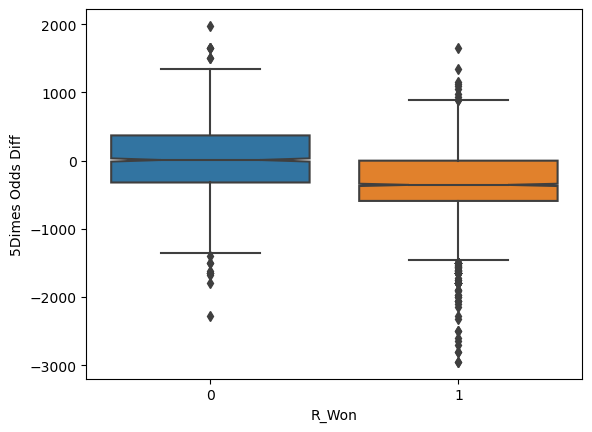

In [131]:
ufc["temp"] = (ufc["R_Winning Streak"] - ufc["R_Losing Streak"]) - (ufc["B_Winning Streak"] - ufc["B_Losing Streak"])
ufc["temp2"] = ufc["R_Cumulative Time Fought"] - ufc["B_Cumulative Time Fought"]
sns.boxplot(x="R_Won", y="5Dimes Odds Diff", data=ufc, notch=True, showcaps=True)

In [132]:
stats.ttest_ind(ufc.loc[ufc["R_Won"] == 0, "5Dimes Odds Diff"], ufc.loc[ufc["R_Won"] == 1, "5Dimes Odds Diff"], equal_var=False)

Ttest_indResult(statistic=27.401502571656003, pvalue=3.453496926685435e-154)